# SemiBoosted Analysis with BDT

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import HH4b.utils as utils
import HH4b.plotting as plotting
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import mplhep as hep
import vector

In [2]:
def make_vector(events: pd.DataFrame, obj: str):
    """Create a ``vector`` object from the columns of the dataframe"""
    mstring = "PNetMass" if obj == "ak8FatJet" else "Mass"

    return vector.array(
        {
            "pt": events[f"{obj}Pt"],
            "phi": events[f"{obj}Phi"],
            "eta": events[f"{obj}Eta"],
            "M": events[f"{obj}{mstring}"],
        }
    )

## Load Dataset

In [3]:
year = "2018"  #
dir_name = "23Nov18_WSel_v9_private"
path_to_dir = f"/Users/billyli/UCSD/{dir_name}/"

In [4]:
# Load your dataset
samples = {
    "hh4b": ["GluGlutoHHto4B_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8"],
    # cHHH = kappa lambda
    # "hh4b-c2p45": ["GluGlutoHHto4B_cHHH2p45_TuneCP5_PSWeights_13TeV-powheg-pythia8"],
    # "hh4b-c5": ["GluGlutoHHto4B_cHHH5_TuneCP5_PSWeights_13TeV-powheg-pythia8"],
    # "hh4b-c0": ["GluGlutoHHto4B_cHHH0_TuneCP5_PSWeights_13TeV-powheg-pythia8"],
    "qcd": [
        "QCD_HT-200to300-13TeV",
        "QCD_HT-300to500-13TeV",
        "QCD_HT-500to700-13TeV",
        "QCD_HT-700to1000-13TeV",
        "QCD_HT-1000to1500-13TeV",
        "QCD_HT-1500to2000-13TeV",
        "QCD_HT-2000toInf-13TeV",
    ],
    "ttbar": [
        "TTTo2L2Nu_13TeV",
        "TTToHadronic_13TeV",
        "TTToSemiLeptonic_13TeV",
    ],
}

dirs = {path_to_dir: samples}

filters = [
    [
        # one good fatjet (fatjet with index 0 has the largest Xbb score)
        ("('ak8FatJetPt', '0')", ">=", 300),
        ("('ak8FatJetMsd', '0')", ">=", 60),
        ("('ak8FatJetPNetXbb', '0')", ">=", 0.9734),  # medium WP
        # second fatjet has lower
        ("('ak8FatJetPNetXbb', '1')", "<", 0.9880),  # tight WP
    ]
]

# columns to load
# the parquet files are too big so we can only load a few columns at a time without consumming much memory
load_columns = [
    ("weight", 1),
    ("ak8FatJetMsd", 2),
    ("ak8FatJetPNetMass", 2),
    ("ak8FatJetPNetXbb", 2),
]
# reformat into ("column name", "idx") format for reading multiindex columns
columns = []
for key, num_columns in load_columns:
    for i in range(num_columns):
        columns.append(f"('{key}', '{i}')")


events_dict = {}
for input_dir, samples in dirs.items():
    events_dict = {
        **events_dict,
        # this function will load files (only the columns selected), apply filters and compute a weight per event
        **utils.load_samples(input_dir, samples, year, filters=filters, load_weight_noxsec=False, reorder_txbb=False),
    }

samples_loaded = list(events_dict.keys())
keys_loaded = list(events_dict[samples_loaded[0]].keys())
print(f"Keys in events_dict")
for i in keys_loaded:
    print(i)

Loading GluGlutoHHto4B_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8
Loaded GluGlutoHHto4B_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8: 17313 entries
Loading QCD_HT-200to300-13TeV
Loading QCD_HT-1000to1500-13TeV
Loaded QCD_HT-1000to1500-13TeV                           : 5063 entries
Loading QCD_HT-500to700-13TeV


/Users/billyli/UCSD/HH4b/src/HH4b/utils.py:346: UserWarning: No events for QCD_HT-200to300-13TeV!
  warnings.warn(f"No events for {sample}!", stacklevel=1)


Loaded QCD_HT-500to700-13TeV                             : 995 entries
Loading QCD_HT-700to1000-13TeV
Loaded QCD_HT-700to1000-13TeV                            : 6868 entries
Loading QCD_HT-300to500-13TeV
Loaded QCD_HT-300to500-13TeV                             : 3 entries
Loading QCD_HT-1500to2000-13TeV
Loaded QCD_HT-1500to2000-13TeV                           : 5878 entries
Loading QCD_HT-2000toInf-13TeV
Loaded QCD_HT-2000toInf-13TeV                            : 2349 entries
Loading TTToHadronic_13TeV
Loaded TTToHadronic_13TeV                                : 241513 entries
Loading TTToSemiLeptonic_13TeV
Loaded TTToSemiLeptonic_13TeV                            : 194522 entries
Loading TTTo2L2Nu_13TeV
Loaded TTTo2L2Nu_13TeV                                   : 28298 entries
Keys in events_dict
('ht', 0)
('nCentralJets', 0)
('nOutsideJets', 0)
('nFatJets', 0)
('vbf_selection', 0)
('GenHiggsEta', 0)
('GenHiggsEta', 1)
('GenHiggsPhi', 0)
('GenHiggsPhi', 1)
('GenHiggsMass', 0)
('GenHiggsMass

## Event cuts

In [5]:
# Higgs candidate selection example
events_raw = pd.concat(
    [events_dict["hh4b"], events_dict["qcd"], events_dict["ttbar"]], keys=["hh4b", "qcd", "ttbar"]
)

In [6]:
# AK4OutsideJet pt cut
jets_outside_raw = make_vector(events_raw, "ak4JetOutside")
j3_raw = jets_outside_raw[:, 0]
j4_raw = jets_outside_raw[:, 1]
j3j4_pt_cut = (j3_raw.pt > 20) & (j4_raw.pt > 20)

In [7]:
combined_filter = j3j4_pt_cut
events = events_raw[combined_filter]

In [66]:
events.loc['ttbar']['weight']

,0
0,7.006429e+09
1,7.006429e+09
2,7.006429e+09
3,7.006429e+09
4,7.006429e+09
...,...
28293,4.011721e+08
28294,4.011721e+08
28295,4.011721e+08
28296,4.011721e+08


In [8]:
list(events.keys())

[('ht', 0),
 ('nCentralJets', 0),
 ('nOutsideJets', 0),
 ('nFatJets', 0),
 ('vbf_selection', 0),
 ('GenHiggsEta', 0),
 ('GenHiggsEta', 1),
 ('GenHiggsPhi', 0),
 ('GenHiggsPhi', 1),
 ('GenHiggsMass', 0),
 ('GenHiggsMass', 1),
 ('GenHiggsPt', 0),
 ('GenHiggsPt', 1),
 ('GenbEta', 0),
 ('GenbEta', 1),
 ('GenbEta', 2),
 ('GenbEta', 3),
 ('GenbPhi', 0),
 ('GenbPhi', 1),
 ('GenbPhi', 2),
 ('GenbPhi', 3),
 ('GenbMass', 0),
 ('GenbMass', 1),
 ('GenbMass', 2),
 ('GenbMass', 3),
 ('GenbPt', 0),
 ('GenbPt', 1),
 ('GenbPt', 2),
 ('GenbPt', 3),
 ('ak4JetHiggsMatch', 0),
 ('ak4JetHiggsMatch', 1),
 ('ak4JetHiggsMatch', 2),
 ('ak4JetHiggsMatch', 3),
 ('ak4JetHiggsMatch', 4),
 ('ak4JetHiggsMatch', 5),
 ('ak4JetHiggsMatchIndex', 0),
 ('ak4JetHiggsMatchIndex', 1),
 ('ak4JetHiggsMatchIndex', 2),
 ('ak4JetHiggsMatchIndex', 3),
 ('ak4JetHiggsMatchIndex', 4),
 ('ak4JetHiggsMatchIndex', 5),
 ('ak4JethadronFlavour', 0),
 ('ak4JethadronFlavour', 1),
 ('ak4JethadronFlavour', 2),
 ('ak4JethadronFlavour', 3),
 ('ak

## Define Targets with weights

In [9]:
def get_yw_from_events(events):
    # Define Targets
    events["target"] = 0  # default is background
    events.loc["hh4b", "target"] = 1  # Set to 1 for 'hh4b' samples (signal)
    
    # define target and weights
    targets_weights = events[["target", "weight"]]
    targets_weights.loc[:, 'weight'] = np.abs(targets_weights.loc[:, 'weight'].to_numpy())
    
    # calculate the sum of weights in signal/bg categories
    signal_mask = targets_weights["target"]==1
    total_signal_weight = targets_weights[signal_mask]['weight'].sum()
    total_bg_weight = targets_weights[~signal_mask]['weight'].sum()

    # balancing classes
    print("total signal weight", total_signal_weight)
    print("total bg weight", total_bg_weight)
    targets_weights.loc[signal_mask, 'bal_weight'] = (targets_weights.loc[signal_mask, 'weight'] / total_signal_weight).to_numpy()
    targets_weights.loc[~signal_mask, 'bal_weight'] = (targets_weights.loc[~signal_mask, 'weight'] / total_bg_weight).to_numpy()



    # normalize weights
    targets_weights.loc[:, 'bal_weight'] = (targets_weights.loc[:, 'bal_weight']/targets_weights.loc[:, 'bal_weight'].max()).to_numpy()

    print("after reweighting and normalizing")
    total_signal_weight = targets_weights[signal_mask]['bal_weight'].sum()
    total_bg_weight = targets_weights[~signal_mask]['bal_weight'].sum()
    print("total signal weight", total_signal_weight)
    print("total bg weight", total_bg_weight)
    
    return targets_weights

In [10]:
targets_weights = get_yw_from_events(events)
targets_weights

total signal weight 0    309536.725753
dtype: float64
total bg weight 0    2.687283e+15
dtype: float64
after reweighting and normalizing
total signal weight 8825.898144700557
total bg weight 8825.898144700552


/var/folders/lf/yggx1zv12tz2k1d1xnx1g6q00000gn/T/ipykernel_54351/769385865.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events["target"] = 0  # default is background
/var/folders/lf/yggx1zv12tz2k1d1xnx1g6q00000gn/T/ipykernel_54351/769385865.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  events.loc["hh4b", "target"] = 1  # Set to 1 for 'hh4b' samples (signal)
/var/folders/lf/yggx1zv12tz2k1d1xnx1g6q00000gn/T/ipykernel_54351/769385865.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

target        weight bal_weight
                               0           
hh4b  0          1  1.881759e+01   0.536551
      1          1  1.881759e+01   0.536551
      2          1  1.881759e+01   0.536551
      3          1  1.881759e+01   0.536551
      4          1  1.881759e+01   0.536551
...            ...           ...        ...
ttbar 28293      0  4.011721e+08   0.001318
      28294      0  4.011721e+08   0.001318
      28295      0  4.011721e+08   0.001318
      28296      0  4.011721e+08   0.001318
      28297      0  4.011721e+08   0.001318

[448822 rows x 3 columns]

## Define Features

In [16]:
def get_x_from_events(events):
    multiIndex = events.index
    events = events.reset_index()
    
    # Use pandas df as feature container
    df = pd.DataFrame()

    # H1 features
    fatjets = make_vector(events, "ak8FatJet")  # fatjets sorted by xbb
    h1 = fatjets[:, 0]
    df["logPtH1"] = np.log(h1.pt)  #
    df["hb_eta"] = h1.eta  #


    # H2 features
    jets_outside = make_vector(events, "ak4JetOutside")  # sorted by b-score
    j3 = jets_outside[:, 0]
    j4 = jets_outside[:, 1]
    h2 = j3 + j4
    df["hr_pt"] = h2.pt  #
    df["hr_eta"] = h2.eta  #
    df["hr_mass"] = h2.mass  #

    # j3 j4 features
    j3_deepJetB = events.ak4JetOutsidebtagDeepFlavB[0]
    j4_deepJetB = events.ak4JetOutsidebtagDeepFlavB[1]

    pn_b = events.ak4JetOutsidebtagPNetProbb + events.ak4JetOutsidebtagPNetProbbb
    pn_c = events.ak4JetOutsidebtagPNetProbc + events.ak4JetOutsidebtagPNetProbcc
    pn_uds = events.ak4JetOutsidebtagPNetProbuds
    pn_g = events.ak4JetOutsidebtagPNetProbg
    ak4JetOutsidePNetFlavB = pn_b / (pn_b + pn_c + pn_uds + pn_g)
    j3_PNetFlavB = ak4JetOutsidePNetFlavB[0]
    j4_PNetFlavB = ak4JetOutsidePNetFlavB[1]

    j3_btag = j3_PNetFlavB
    j4_btag = j4_PNetFlavB

    df["logPtJ3"] = np.log(j3.pt)  #
    df["logPtJ4"] = np.log(j4.pt)  #
    df["j3_btag"] = j3_btag  #
    df["j4_btag"] = j4_btag  #

    df["dPhiJ3J4"] = j3.deltaphi(j4)
    df["dRJ3J4"] = j3.deltaR(j4)  #
    df["j3_j4_ratio"] = j3.pt / j4.pt  #

    # HH features
    hh = h1 + h2
    drh1h2 = np.sqrt((h1.eta - h2.eta) ** 2 + (h1.phi - h2.phi) ** 2)

    df["logPtHH"] = np.log(hh.pt)  #
    df["HHMass"] = hh.M  #
    df["HHEta"] = hh.eta  #  #

    df["H1Pt_H2Pt"] = h1.pt / h2.pt  #
    df["dphi"] = h1.deltaphi(h2)  #
    df["deta"] = h1.deltaeta(h2)  #
    df["dRH1H2"] = drh1h2  #

    # Second fatjet
    fj2 = fatjets[:, 1]
    df["fj2_pt"] = fj2.pt  #
    df["fj2_eta"] = fj2.eta  #
    df["fj2_mass"] = fj2.M  #
    
    features = df.set_index(multiIndex)
    return features

In [17]:
features = get_x_from_events(events)

In [18]:
# Splitting the dataset into (training & validating) and testing sets
# train:val:test = 6:2:2
X_train_val, X_test, yw_train_val, yw_test = train_test_split(
    features, targets_weights, test_size=0.2, random_state=42
)

y_test = yw_test["target"]
w_test = yw_test["bal_weight"]

In [19]:
X_train, X_val, yw_train, yw_val = train_test_split(
    X_train_val, yw_train_val, test_size=0.25, random_state=42
)

y_train = yw_train["target"]
w_train = yw_train["bal_weight"]

y_val = yw_val["target"]
w_val = yw_val["bal_weight"]

In [20]:
events_train_val, events_test, _, _ = train_test_split(
    events, targets_weights, test_size=0.2, random_state=42
)

In [16]:
def test_0_denom(events_test_0):
    events_test_0 = events_test_dfs[0]

    j3_deepJetB = events_test_0 .ak4JetOutsidebtagDeepFlavB[0]
    j4_deepJetB = events_test_0 .ak4JetOutsidebtagDeepFlavB[1]

    pn_b = events_test_0 .ak4JetOutsidebtagPNetProbb + events_test_0 .ak4JetOutsidebtagPNetProbbb
    pn_c = events_test_0 .ak4JetOutsidebtagPNetProbc + events_test_0 .ak4JetOutsidebtagPNetProbcc
    pn_uds = events_test_0 .ak4JetOutsidebtagPNetProbuds
    pn_g = events_test_0 .ak4JetOutsidebtagPNetProbg
    
    return np.any((pn_c + pn_uds + pn_g) == 0)

In [17]:
np.isnan(X_train.loc[:, 'j3_btag']).any()

True

## Load model

In [21]:
# Initialize the BDT model
bdt_model = XGBClassifier(
    n_estimators=196, max_depth=17, learning_rate=0.1, subsample=0.5, random_state=42
)

In [22]:
print(np.sum(w_train))

10624.806993388616


In [23]:
# Train the model
bdt_model.fit(X_train, y_train, sample_weight=w_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=17, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=196, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

## Validate model

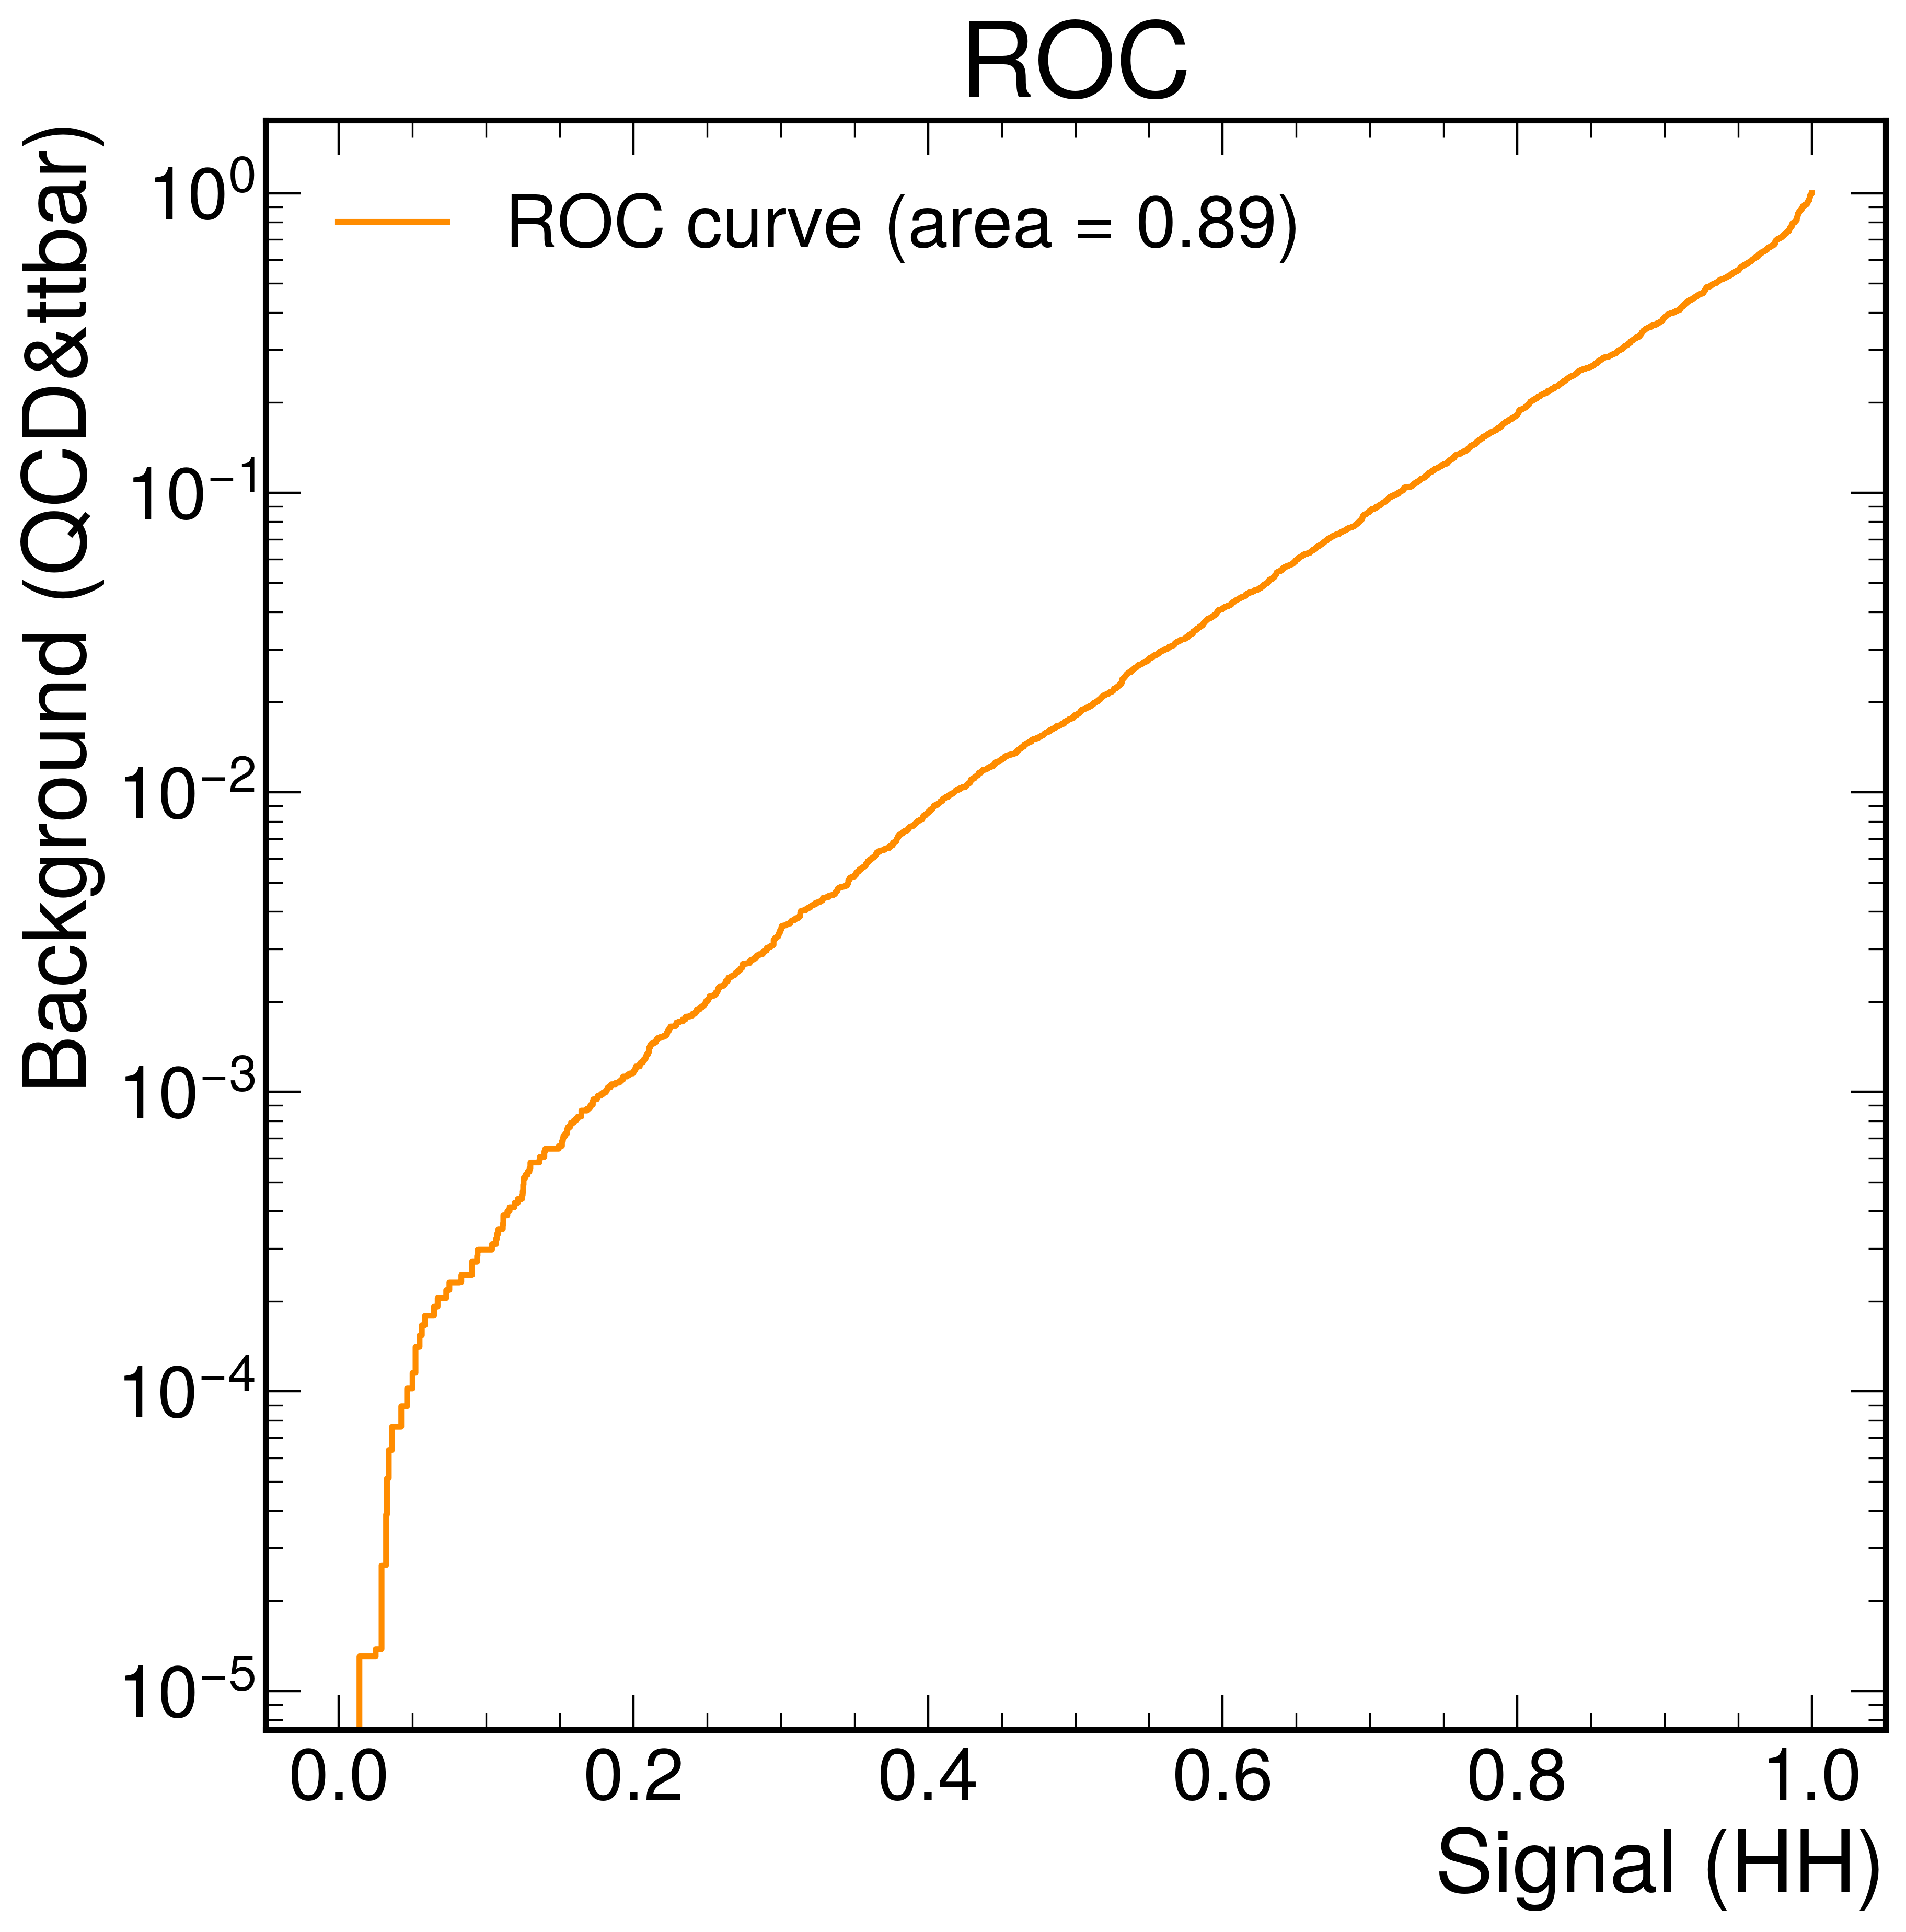

In [24]:
y_val_scores = bdt_model.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_val_scores, sample_weight=w_val)
roc_auc = auc(fpr, tpr)

# histogram for y scores signal & background
# rank by importance

# number of b-jets that can be identified in resolved
# another feather cos(theta_star)

# Plottting
plt.figure()
plt.plot(tpr, fpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.xlabel("Signal (HH)")
plt.ylabel("Background (QCD&ttbar)")
plt.title("ROC")
plt.legend(loc="upper left")
plt.yscale("log")
plt.show()

## Calculate Yields

yeild = sum of weights_passed

### Calculate efficiecy per bin

In [25]:
hh_mass_bins = np.arange(400, 1601, 400)

In [26]:
threshold = 0.5

In [27]:
hh4b_scores = bdt_model.predict_proba(X_test.loc["hh4b"])[:, 1]
qcd_scores = bdt_model.predict_proba(X_test.loc["qcd"])[:, 1]
ttbar_scores = bdt_model.predict_proba(X_test.loc["ttbar"])[:, 1]

In [78]:
thresholds =  [0.5, 0.7, 0.8, 0.9, 0.95, 0.99]
signal_yields = []
qcd_yields = []
ttbar_yields = []
bg_yields = []

for threshold in thresholds:
    signal_yield = events_test.loc["hh4b"][hh4b_scores > threshold]["weight_nonorm"].sum()
    qcd_yield = events_test.loc["qcd"][qcd_scores > threshold]["weight_nonorm"].sum()
    ttbar_yield = events_test.loc["ttbar"][ttbar_scores > threshold]["weight_nonorm"].sum()
    bg_yield = qcd_yield + ttbar_yield
    
    signal_yields.append(signal_yield)
    qcd_yields.append(qcd_yield)
    ttbar_yields.append(ttbar_yield)
    bg_yields.append(bg_yield)

In [59]:
ttbar_yields

[0    2.391534e+13
 dtype: float64,
 0    1.220580e+13
 dtype: float64,
 0    8.400776e+12
 dtype: float64,
 0    4.487954e+12
 dtype: float64,
 0    2.164205e+12
 dtype: float64,
 0    2.223080e+11
 dtype: float64]

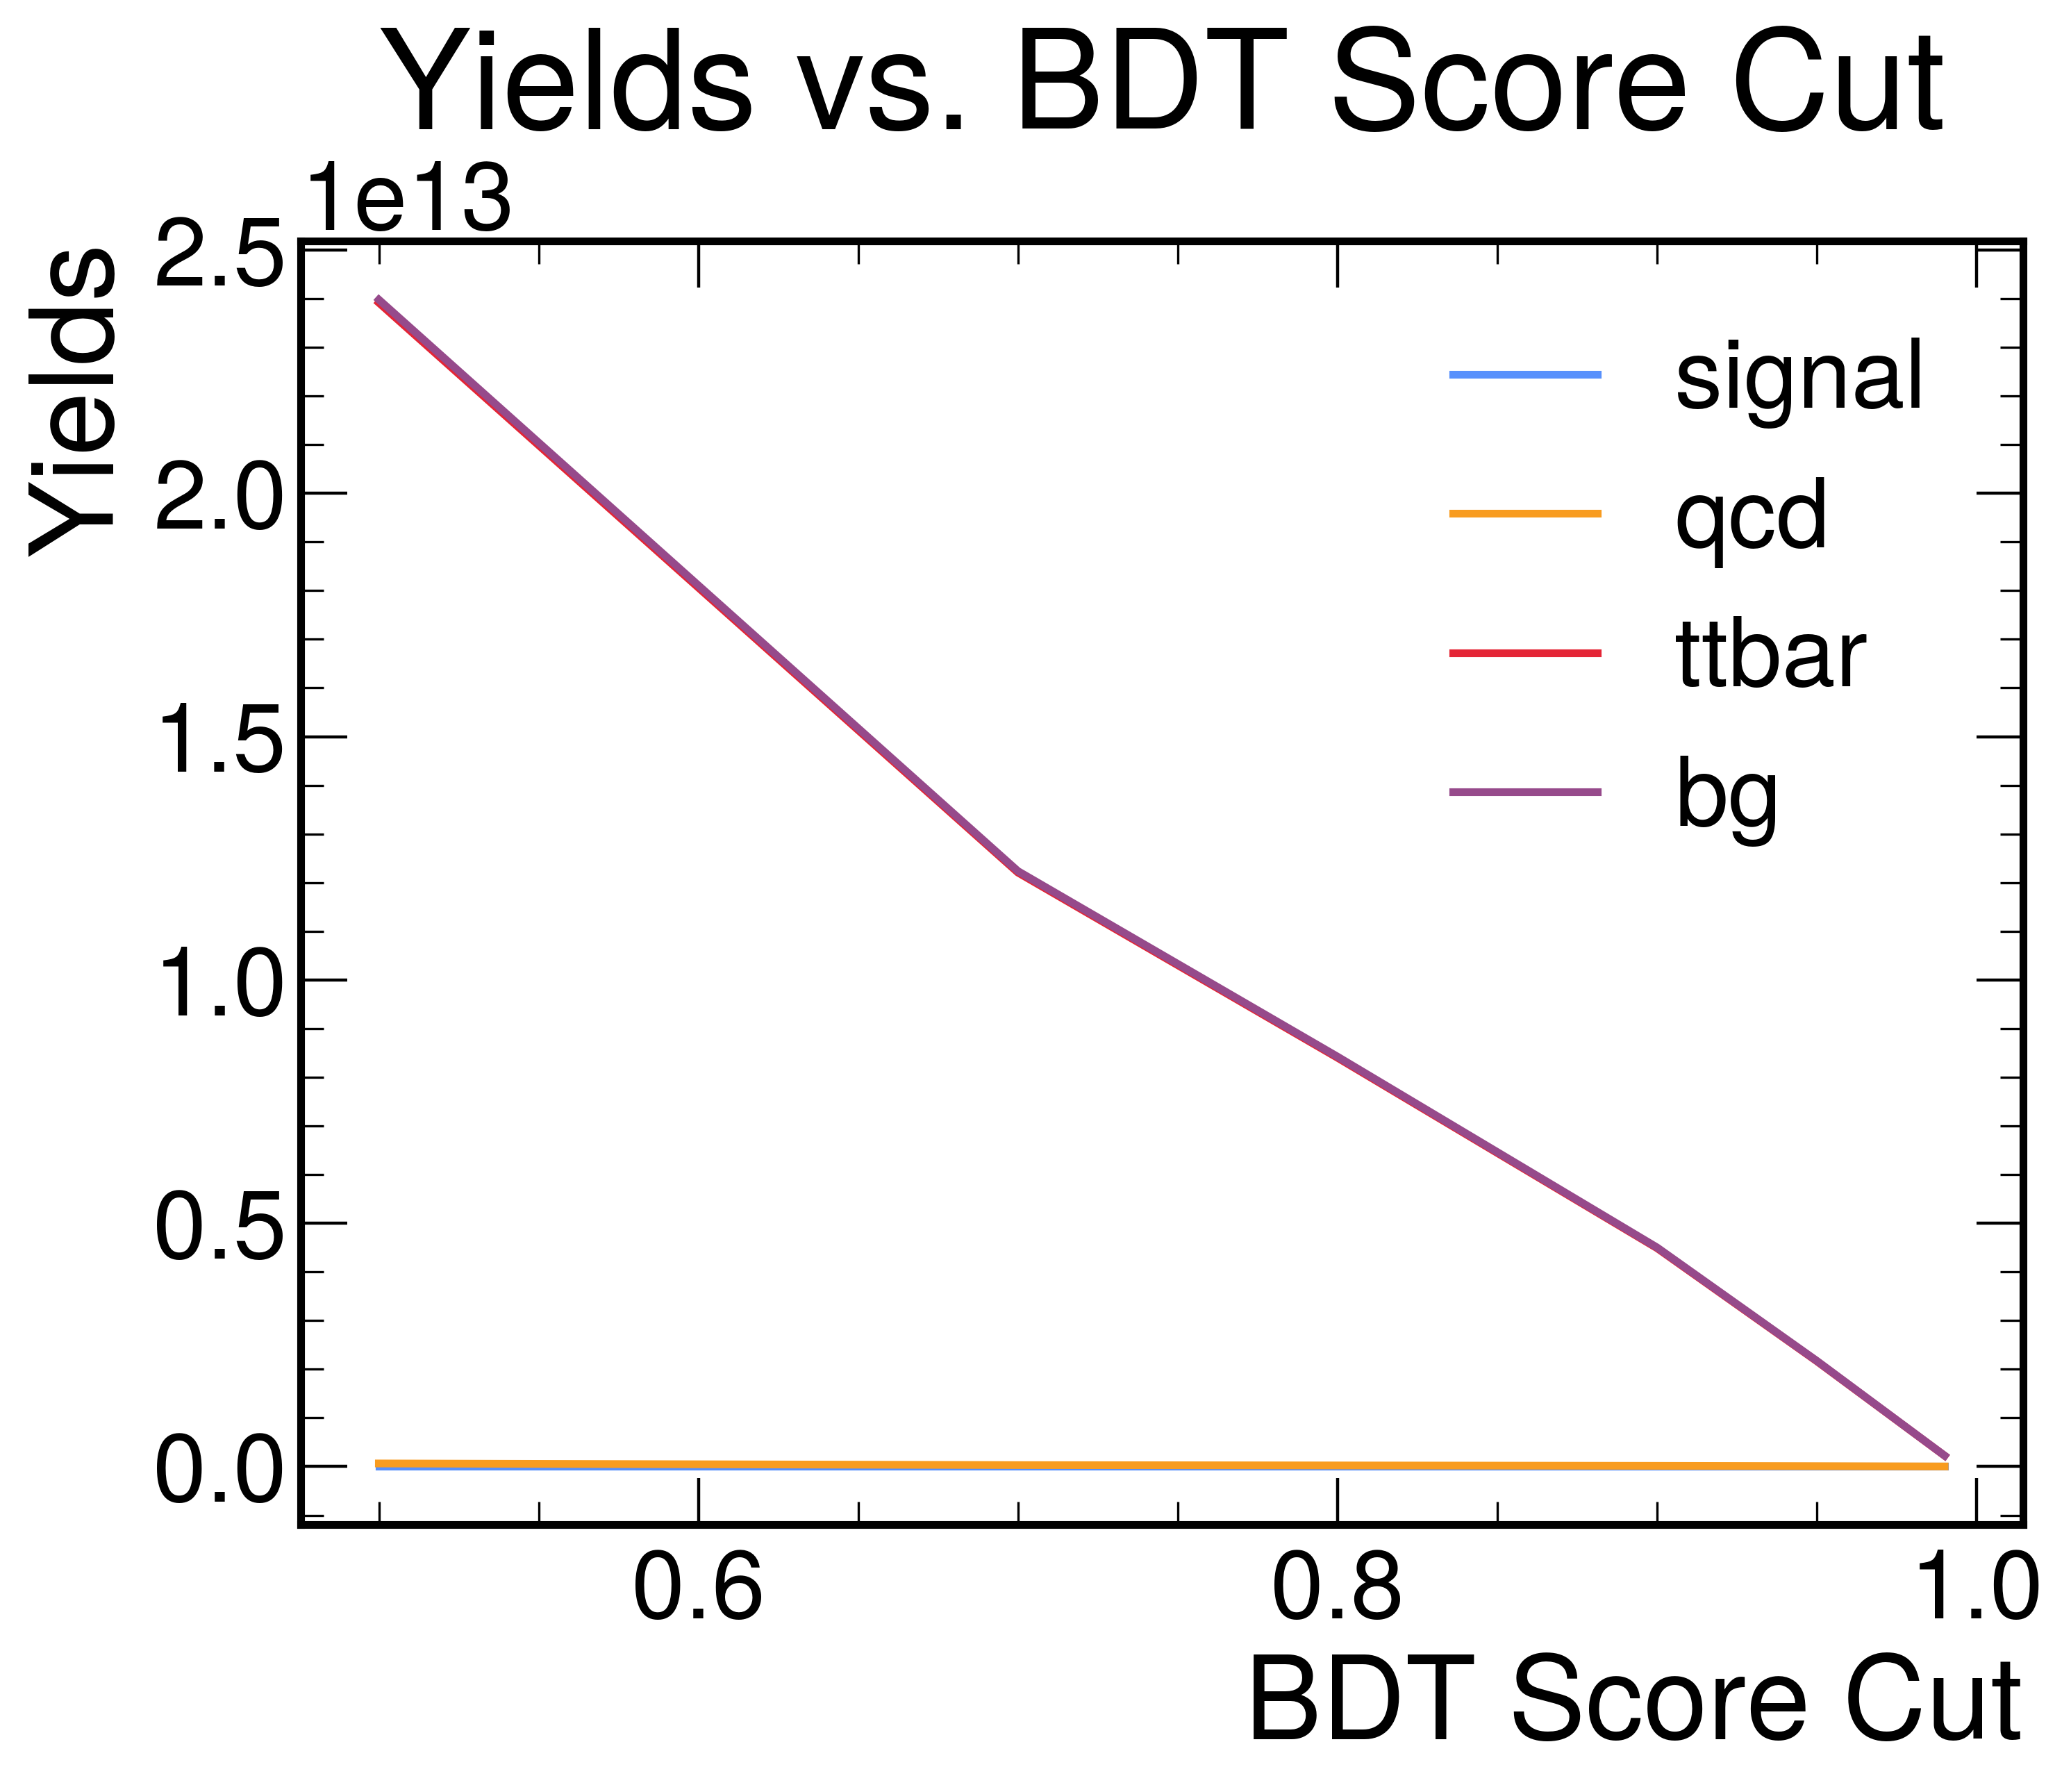

In [79]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(thresholds, signal_yields, label='signal')
ax.plot(thresholds, qcd_yields, label='qcd')
ax.plot(thresholds, ttbar_yields, label='ttbar')
ax.plot(thresholds, bg_yields, label='bg')
ax.legend()
ax.set(title="Yields vs. BDT Score Cut", xlabel="BDT Score Cut", ylabel="Yields")
plt.show()

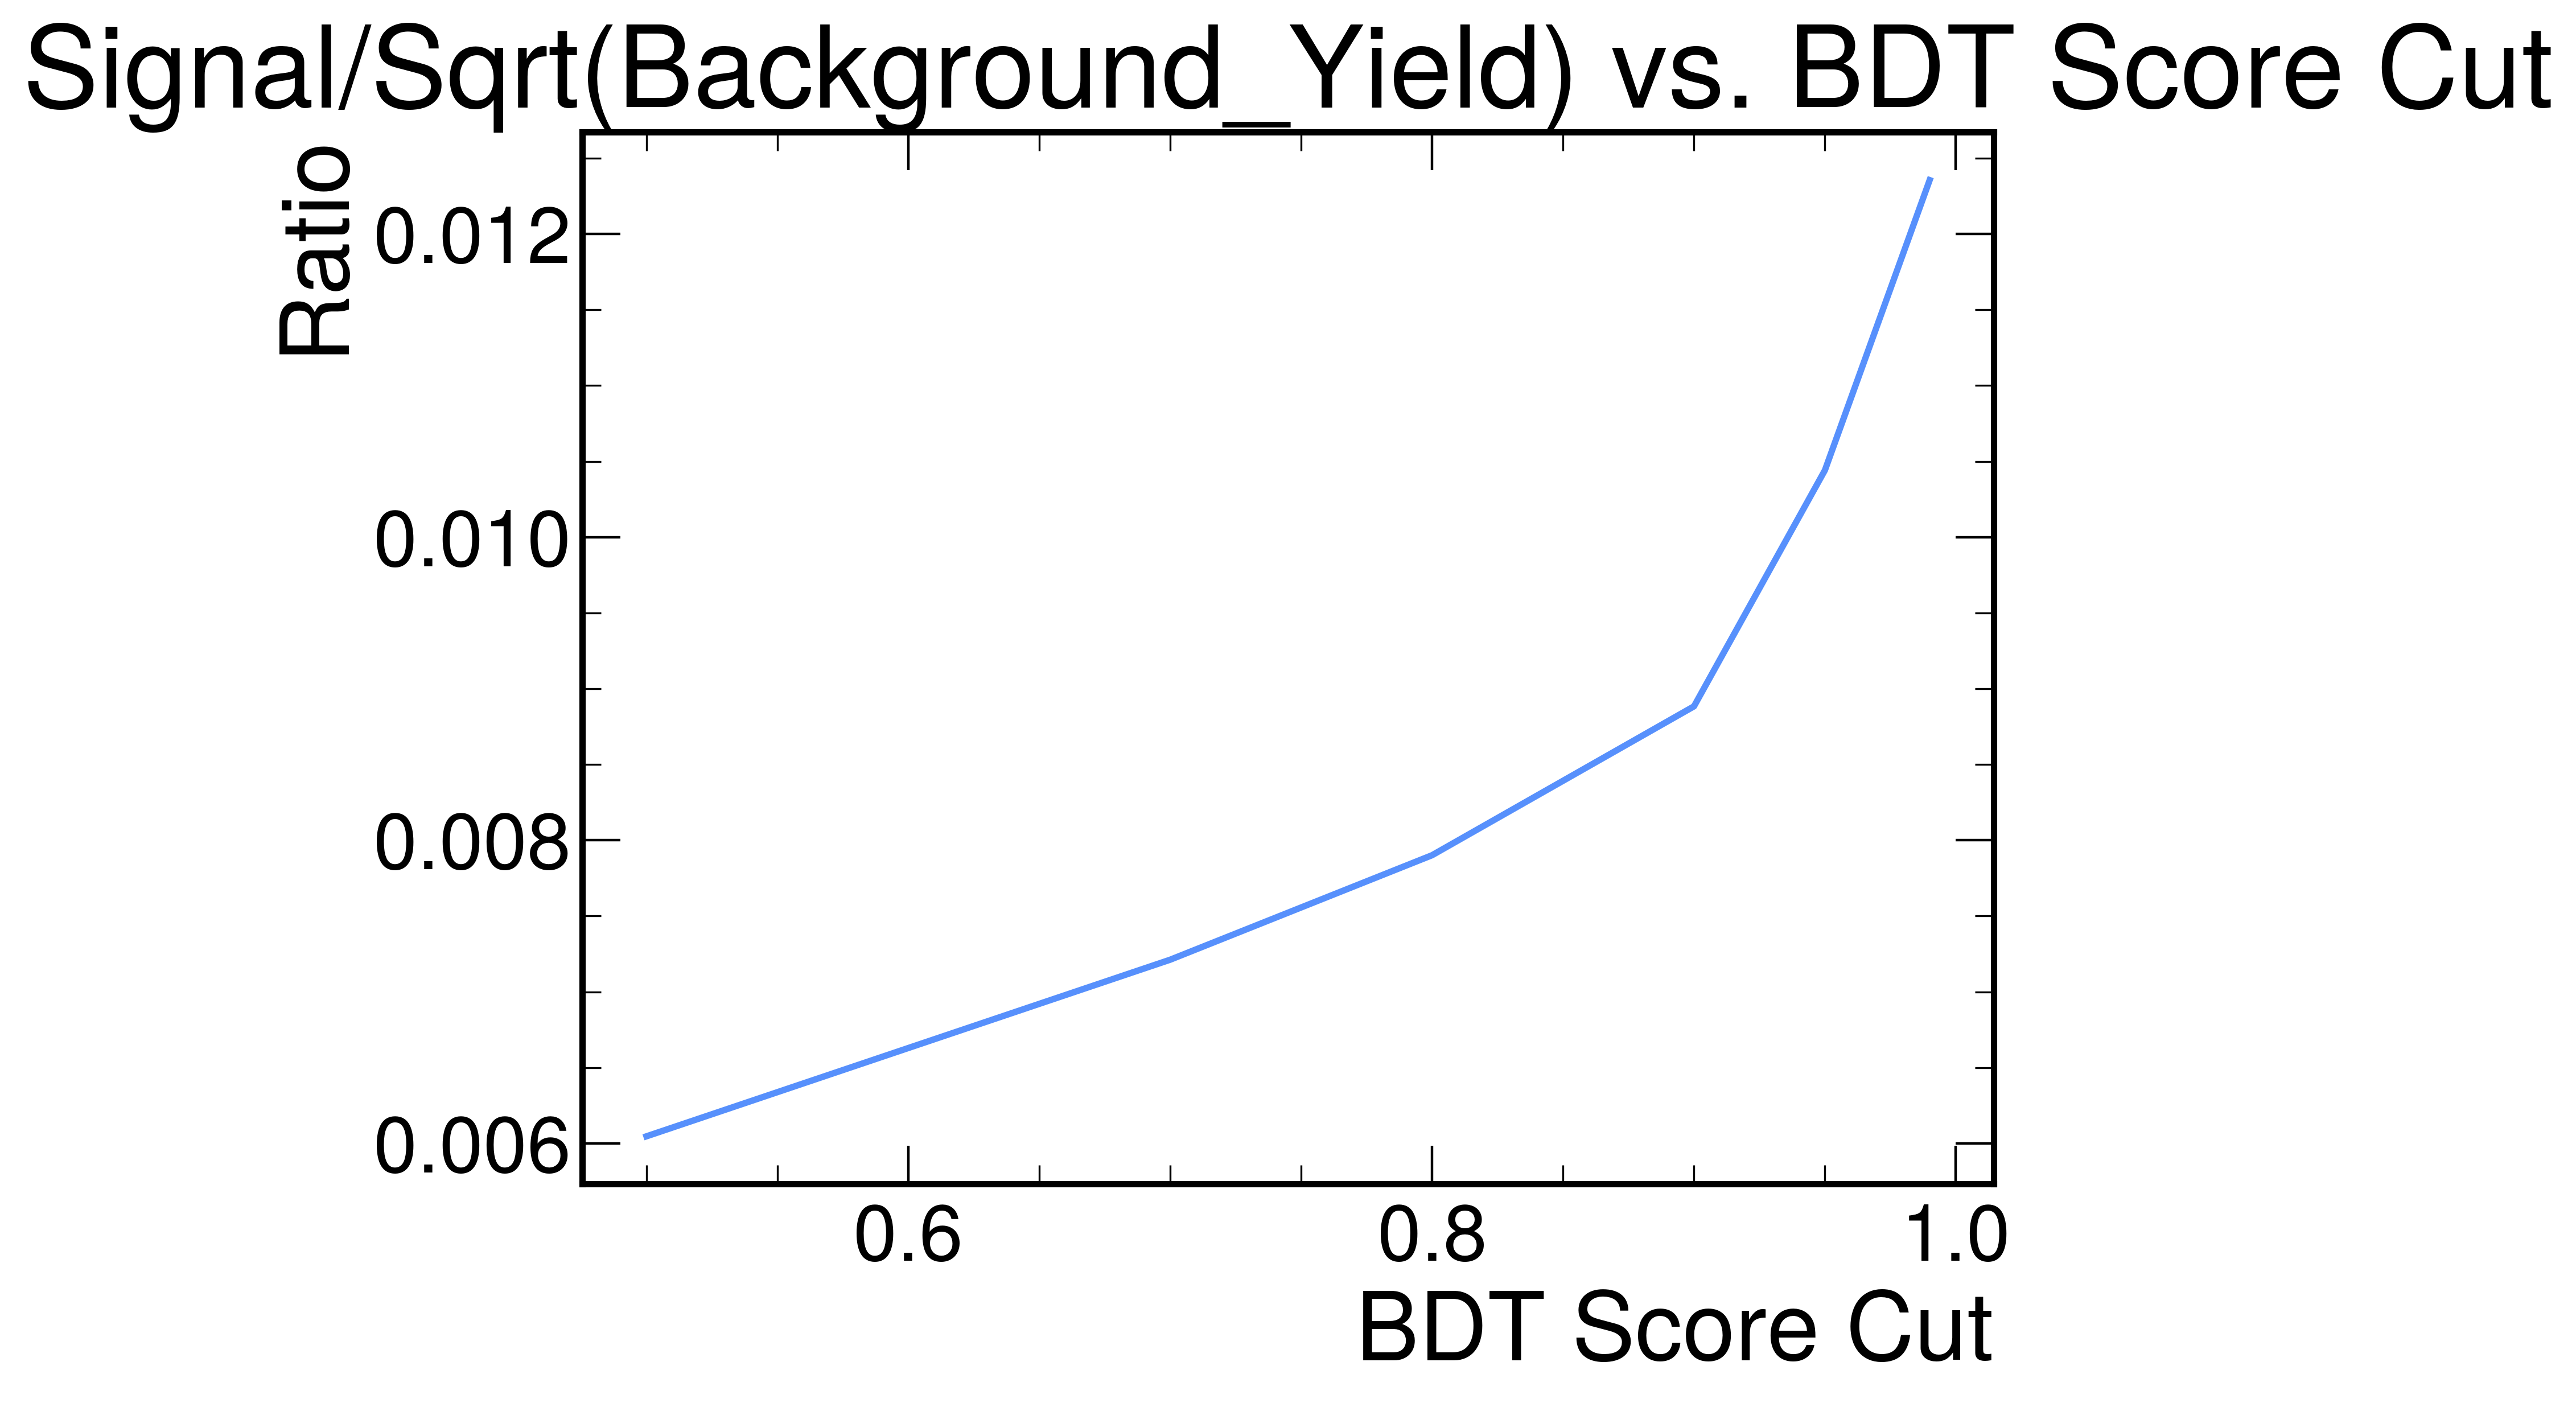

In [80]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(thresholds, signal_yields/np.sqrt(bg_yields))
ax.set(title="Signal/Sqrt(Background_Yield) vs. BDT Score Cut", xlabel="BDT Score Cut", ylabel="Ratio")
plt.show()

In [32]:
def get_HH_mass(events):
    fatjets = make_vector(events, "ak8FatJet")  # fatjets sorted by xbb
    h1 = fatjets[:, 0]

    jets_outside = make_vector(events, "ak4JetOutside")  # sorted by b-score
    j3 = jets_outside[:, 0]
    j4 = jets_outside[:, 1]
    h2 = j3 + j4
    
    hh = h1 + h2
    return hh.mass

In [33]:
hh_mass = get_HH_mass(events_test)

In [34]:
bin_indices = np.digitize(hh_mass, hh_mass_bins)
print(np.min(bin_indices), np.max(bin_indices))

0 4


In [35]:
events_test['hh_mass'] = hh_mass

In [36]:
dtypes = events_test.dtypes

In [37]:
events_test_list_bins = [[], [], [], [], []]
for index, event in zip(bin_indices, events_test.iterrows()):
    events_test_list_bins[index].append(event[1])

In [38]:
events_test_dfs = [[], [], [], [], []]
for i, events_test_list_per_bin in enumerate(events_test_list_bins):
    events_test_dfs[i] = pd.concat(events_test_list_per_bin, axis=1).transpose().astype(dtypes)

In [39]:
def calc_eff_bmr(events, bdt, threshold):
    # eff = closest tpr
    
    # get x and y
    x = get_x_from_events(events)
    yw = get_yw_from_events(events)
    y = yw['target']
    w = yw['weight']
    
    # get predicted scores
    y_scores = bdt.predict_proba(x)[:, 1]
    fpr, tpr, thresholds = roc_curve(y, y_scores, sample_weight=w)
    nearest_threshold_index = np.abs(thresholds - threshold).argmin()
    
    eff = tpr[nearest_threshold_index]
    bmr = fpr[nearest_threshold_index]
    return eff, bmr

In [40]:
effs_per_bins = []
bmrs_per_bins = []
for events_df_per_bin in events_test_dfs:
    eff, bmr = calc_eff_bmr(events_df_per_bin, bdt_model, threshold)
    effs_per_bins.append(eff)
    bmrs_per_bins.append(bmr)

/var/folders/lf/yggx1zv12tz2k1d1xnx1g6q00000gn/T/ipykernel_54351/769385865.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  events.loc["hh4b", "target"] = 1  # Set to 1 for 'hh4b' samples (signal)
/var/folders/lf/yggx1zv12tz2k1d1xnx1g6q00000gn/T/ipykernel_54351/769385865.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targets_weights.loc[signal_mask, 'bal_weight'] = (targets_weights.loc[signal_mask, 'weight'] / total_signal_weight).to_numpy()


total signal weight 0    733.886062
dtype: float64
total bg weight 0    2.552663e+13
dtype: float64
after reweighting and normalizing
total signal weight 39.0
total bg weight 38.99999999999996


/var/folders/lf/yggx1zv12tz2k1d1xnx1g6q00000gn/T/ipykernel_54351/769385865.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  events.loc["hh4b", "target"] = 1  # Set to 1 for 'hh4b' samples (signal)
/var/folders/lf/yggx1zv12tz2k1d1xnx1g6q00000gn/T/ipykernel_54351/769385865.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targets_weights.loc[signal_mask, 'bal_weight'] = (targets_weights.loc[signal_mask, 'weight'] / total_signal_weight).to_numpy()


total signal weight 0    38975.459891
dtype: float64
total bg weight 0    2.672697e+14
dtype: float64
after reweighting and normalizing
total signal weight 1140.3490934382612
total bg weight 1140.3490934382617


/var/folders/lf/yggx1zv12tz2k1d1xnx1g6q00000gn/T/ipykernel_54351/769385865.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  events.loc["hh4b", "target"] = 1  # Set to 1 for 'hh4b' samples (signal)
/var/folders/lf/yggx1zv12tz2k1d1xnx1g6q00000gn/T/ipykernel_54351/769385865.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targets_weights.loc[signal_mask, 'bal_weight'] = (targets_weights.loc[signal_mask, 'weight'] / total_signal_weight).to_numpy()
/var/folders/lf/yggx1zv12tz2k1d1xnx1g6q00000gn/T/ipykernel_54351/769385865.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  events.loc["hh4b", "target"] = 1  # Set to 1 for 'hh4b' samples (signal)
/var/folders/lf/yggx1zv12tz2k1d1xnx1g6q00000g

total signal weight 0    19182.338751
dtype: float64
total bg weight 0    1.713756e+14
dtype: float64
after reweighting and normalizing
total signal weight 561.5126791006323
total bg weight 561.5126791006323
total signal weight 0    1862.941542
dtype: float64
total bg weight 0    5.115772e+13
dtype: float64
after reweighting and normalizing
total signal weight 99.0
total bg weight 98.99999999999999
total signal weight 0    451.622192
dtype: float64
total bg weight 0    2.256504e+13
dtype: float64
after reweighting and normalizing
total signal weight 24.0
total bg weight 23.999999999999996


/var/folders/lf/yggx1zv12tz2k1d1xnx1g6q00000gn/T/ipykernel_54351/769385865.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targets_weights.loc[signal_mask, 'bal_weight'] = (targets_weights.loc[signal_mask, 'weight'] / total_signal_weight).to_numpy()


In [41]:
events_test_dfs[0]['weight_nonorm']

ttbar  123750    6.706154e+09
       188169    7.006429e+09
       26320     6.706154e+09
       87088     6.706154e+09
       73993     6.706154e+09
                     ...     
       166951    7.006429e+09
       79339     7.006429e+09
       161121    7.006429e+09
       231640    7.006429e+09
       219946    7.006429e+09
Name: weight_nonorm, Length: 4128, dtype: float64

## Make BDT score cuts

In [42]:
def BDT_classify(events, BDT_scores, cut):
    signal_idx = BDT_scores >= cut
    bg_idx = ~signal_idx

    signals = events[signal_idx]
    backgrounds = events[bg_idx]
    return signals, backgrounds

In [43]:
threshold = 0.95

In [44]:
BDTsignals_hh4b, _ = BDT_classify(events_test.loc["hh4b"], hh4b_scores, threshold)
BDTsignals_qcd, _ = BDT_classify(events_test.loc["qcd"], qcd_scores, threshold)
BDTsignals_ttbar, _ = BDT_classify(events_test.loc["ttbar"], ttbar_scores, threshold)

In [45]:
# Get BDT scores
hh4b_scores = bdt_model.predict_proba(X_test.loc["hh4b"])[:, 1]
qcd_scores = bdt_model.predict_proba(X_test.loc["qcd"])[:, 1]
ttbar_scores = bdt_model.predict_proba(X_test.loc["ttbar"])[:, 1]

BDT_scores = [hh4b_scores, qcd_scores, ttbar_scores]

## Construct analysis pipeline

Events -> BDT -> Signal/Bg

Plot signals with gen categories

In [46]:
# Get BDT scores
hh4b_scores = bdt_model.predict_proba(X_test.loc["hh4b"])[:, 1]
qcd_scores = bdt_model.predict_proba(X_test.loc["qcd"])[:, 1]
ttbar_scores = bdt_model.predict_proba(X_test.loc["ttbar"])[:, 1]

BDT_scores = [hh4b_scores, qcd_scores, ttbar_scores]

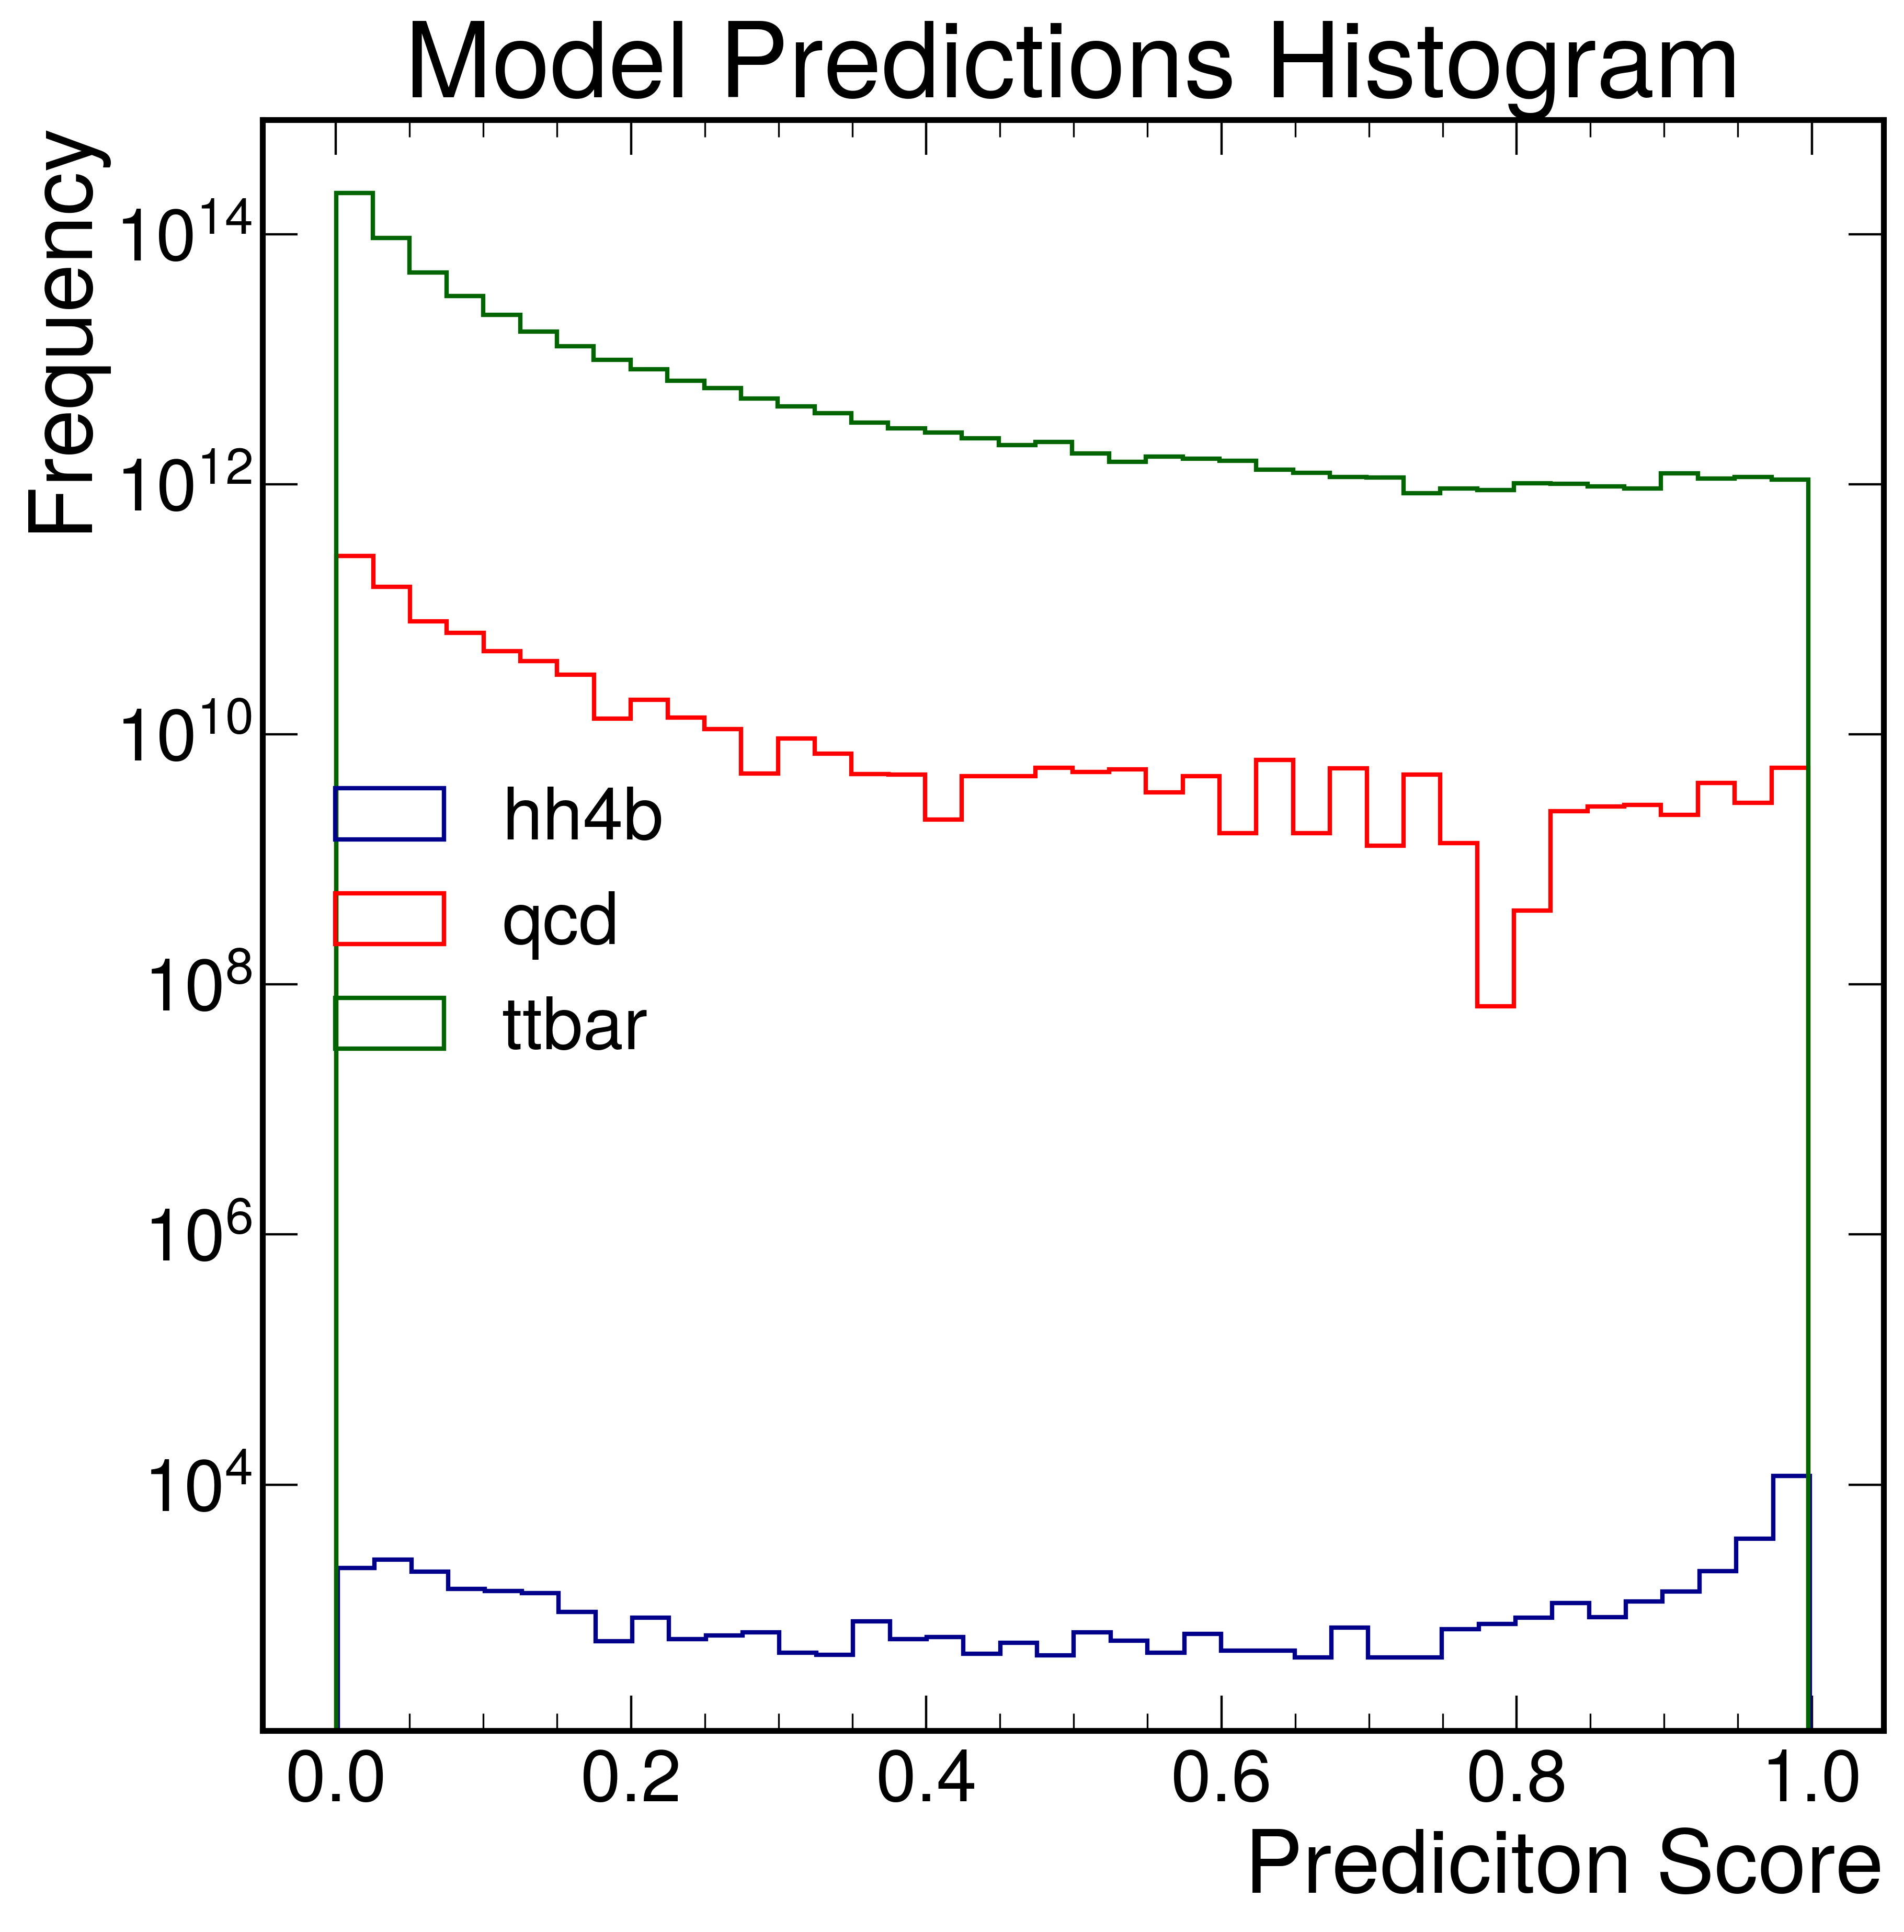

In [83]:
plt.figure()
plt.hist(hh4b_scores, weights=events_test.loc["hh4b"]['weight'], bins=40, histtype="step", linewidth=1.5, color="darkblue")
plt.hist(qcd_scores, weights=events_test.loc["qcd"]['weight'], bins=40, histtype="step", linewidth=1.5, color="red")
plt.hist(ttbar_scores, weights=events_test.loc["ttbar"]['weight'], bins=40, histtype="step", linewidth=1.5, color="darkgreen")
plt.legend(["hh4b", "qcd", "ttbar"])
plt.ylabel("Frequency")
plt.xlabel("Prediciton Score")
plt.title("Model Predictions Histogram")
plt.yscale("log")
plt.show()

In [48]:
# Categorize with a threshold

In [49]:
def BDT_classify(events, BDT_scores, cut):
    signal_idx = BDT_scores >= cut
    bg_idx = ~signal_idx

    signals = events[signal_idx]
    backgrounds = events[bg_idx]
    return signals, backgrounds

In [50]:
## helper functions

In [51]:
def get_H1_mass(events):
    fatjets = make_vector(events, "ak8FatJet")  # fatjets sorted by xbb
    h1 = fatjets[:, 0]
    return h1.mass

In [52]:
def get_H2_mass(events):
    jets_outside = make_vector(events, "ak4JetOutside")  # sorted by b-score
    j3 = jets_outside[:, 0]
    j4 = jets_outside[:, 1]
    h2 = j3 + j4
    return h2.mass

In [53]:
def get_HH_mass(events):
    fatjets = make_vector(events, "ak8FatJet")  # fatjets sorted by xbb
    h1 = fatjets[:, 0]

    jets_outside = make_vector(events, "ak4JetOutside")  # sorted by b-score
    j3 = jets_outside[:, 0]
    j4 = jets_outside[:, 1]
    h2 = j3 + j4
    
    hh = h1 + h2
    return hh.mass

In [84]:
def analyze_SemiBoosted_BDT_output(events_test, BDT_scores, threshold, tag):
    hh4b_scores, qcd_scores, ttbar_scores = BDT_scores
    
    hh4b_weights = events_test.loc["hh4b"][hh4b_scores > threshold]['weight']
    qcd_weights = events_test.loc["qcd"][qcd_scores > threshold]['weight']
    ttbar_weights = events_test.loc["ttbar"][ttbar_scores > threshold]['weight']

    BDTsignals_hh4b, _ = BDT_classify(events_test.loc["hh4b"], hh4b_scores, threshold)
    BDTsignals_qcd, _ = BDT_classify(events_test.loc["qcd"], qcd_scores, threshold)
    BDTsignals_ttbar, _ = BDT_classify(events_test.loc["ttbar"], ttbar_scores, threshold)

    # H1 mass
    h1_mass_hh4b = get_H1_mass(BDTsignals_hh4b)
    h1_mass_qcd = get_H1_mass(BDTsignals_qcd)
    h1_mass_ttbar = get_H1_mass(BDTsignals_ttbar)

    plt.figure()
    plt.hist(h1_mass_hh4b, bins=np.linspace(0, 250, 50), weights=hh4b_weights,
             histtype="step", linewidth=1.5, color="darkblue")
    plt.hist(h1_mass_qcd, bins=np.linspace(0, 250, 50), weights=qcd_weights,
             histtype="step", linewidth=1.5, color="red")
    plt.hist(h1_mass_ttbar, bins=np.linspace(0, 250, 50), weights=ttbar_weights, histtype="step", linewidth=1.5, color="darkgreen")
    plt.legend(["hh4b", "qcd", "ttbar"])
    plt.ylabel("Frequency")
    plt.xlabel("H1 Mass (GeV)")
    plt.title(f"BDT SemiBoosted Signal's H1 Mass {tag}")
    plt.savefig(f"BDT_signal_H1_mass_{tag}.png")

    # H2 mass
    h2_mass_hh4b = get_H2_mass(BDTsignals_hh4b)
    h2_mass_qcd = get_H2_mass(BDTsignals_qcd)
    h2_mass_ttbar = get_H2_mass(BDTsignals_ttbar)
    
    plt.figure()
    plt.hist(h2_mass_hh4b, bins=np.linspace(0, 250, 50), # weights=hh4b_weights,
             histtype="step", linewidth=1.5, color="darkblue")
    plt.hist(h2_mass_qcd, bins=np.linspace(0, 250, 50), # weights=qcd_weights,
             histtype="step", linewidth=1.5, color="red")
    # plt.hist(h2_mass_ttbar, bins=np.linspace(0, 250, 50), weights=ttbar_weights, histtype="step", linewidth=1.5, color="darkgreen")
    plt.legend(["hh4b", "qcd", "ttbar"])
    plt.ylabel("Frequency")
    plt.xlabel("H2 Mass (GeV)")
    plt.title(f"BDT SemiBoosted Signal's H2 Mass {tag}")
    plt.savefig(f"BDT_signal_H2_mass_{tag}.png")

    # HH mass
    hh_mass_hh4b = get_HH_mass(BDTsignals_hh4b)
    hh_mass_qcd = get_HH_mass(BDTsignals_qcd)
    hh_mass_ttbar = get_HH_mass(BDTsignals_ttbar)
    
    plt.figure()
    plt.hist(hh_mass_hh4b, bins=np.linspace(0, 1800, 50), # weights=hh4b_weights,
             histtype="step", linewidth=1.5, color="darkblue")
    plt.hist(hh_mass_qcd, bins=np.linspace(0, 1800, 50), # weights=qcd_weights,
             histtype="step", linewidth=1.5, color="red")
    # plt.hist(hh_mass_ttbar, bins=np.linspace(0, 1800, 50), weights=ttbar_weights, histtype="step", linewidth=1.5, color="darkgreen")
    plt.legend(["hh4b", "qcd", "ttbar"])
    plt.ylabel("Frequency")
    plt.xlabel("HH Mass (GeV)")
    plt.title(f"BDT SemiBoosted Signal's HH mass {tag}")
    plt.savefig(f"BDT_signal_HH_mass_{tag}.png")

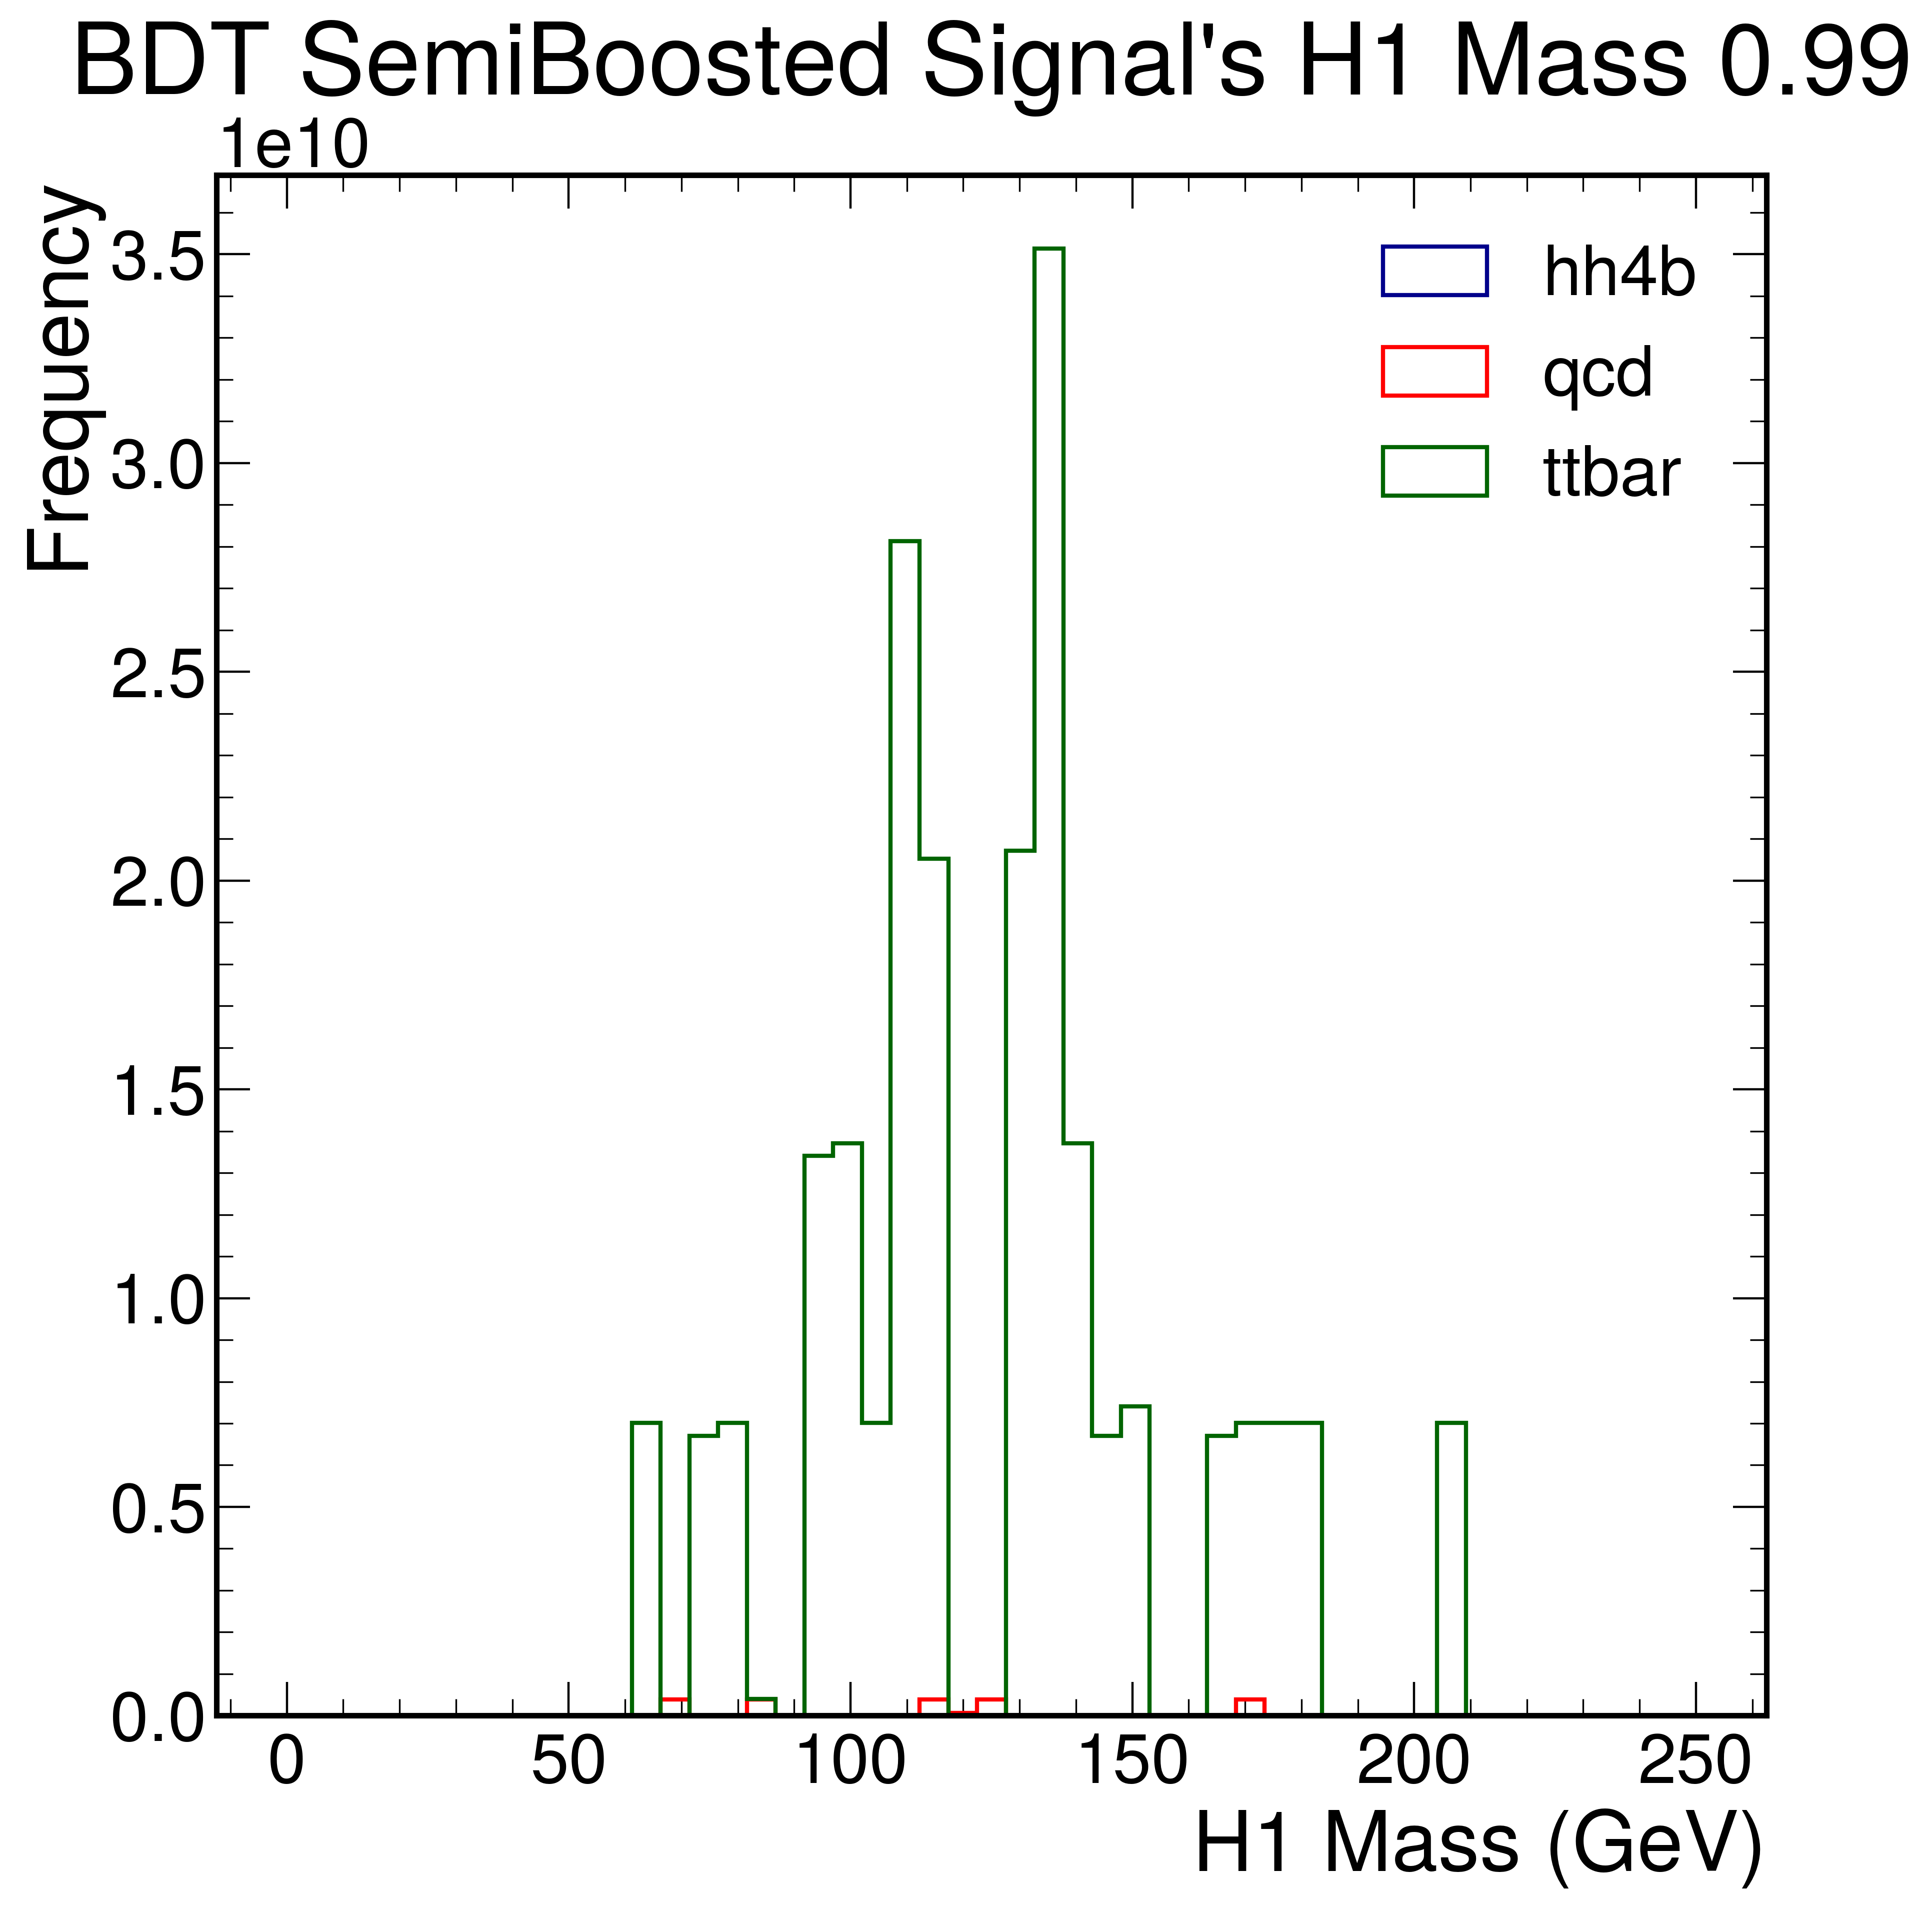

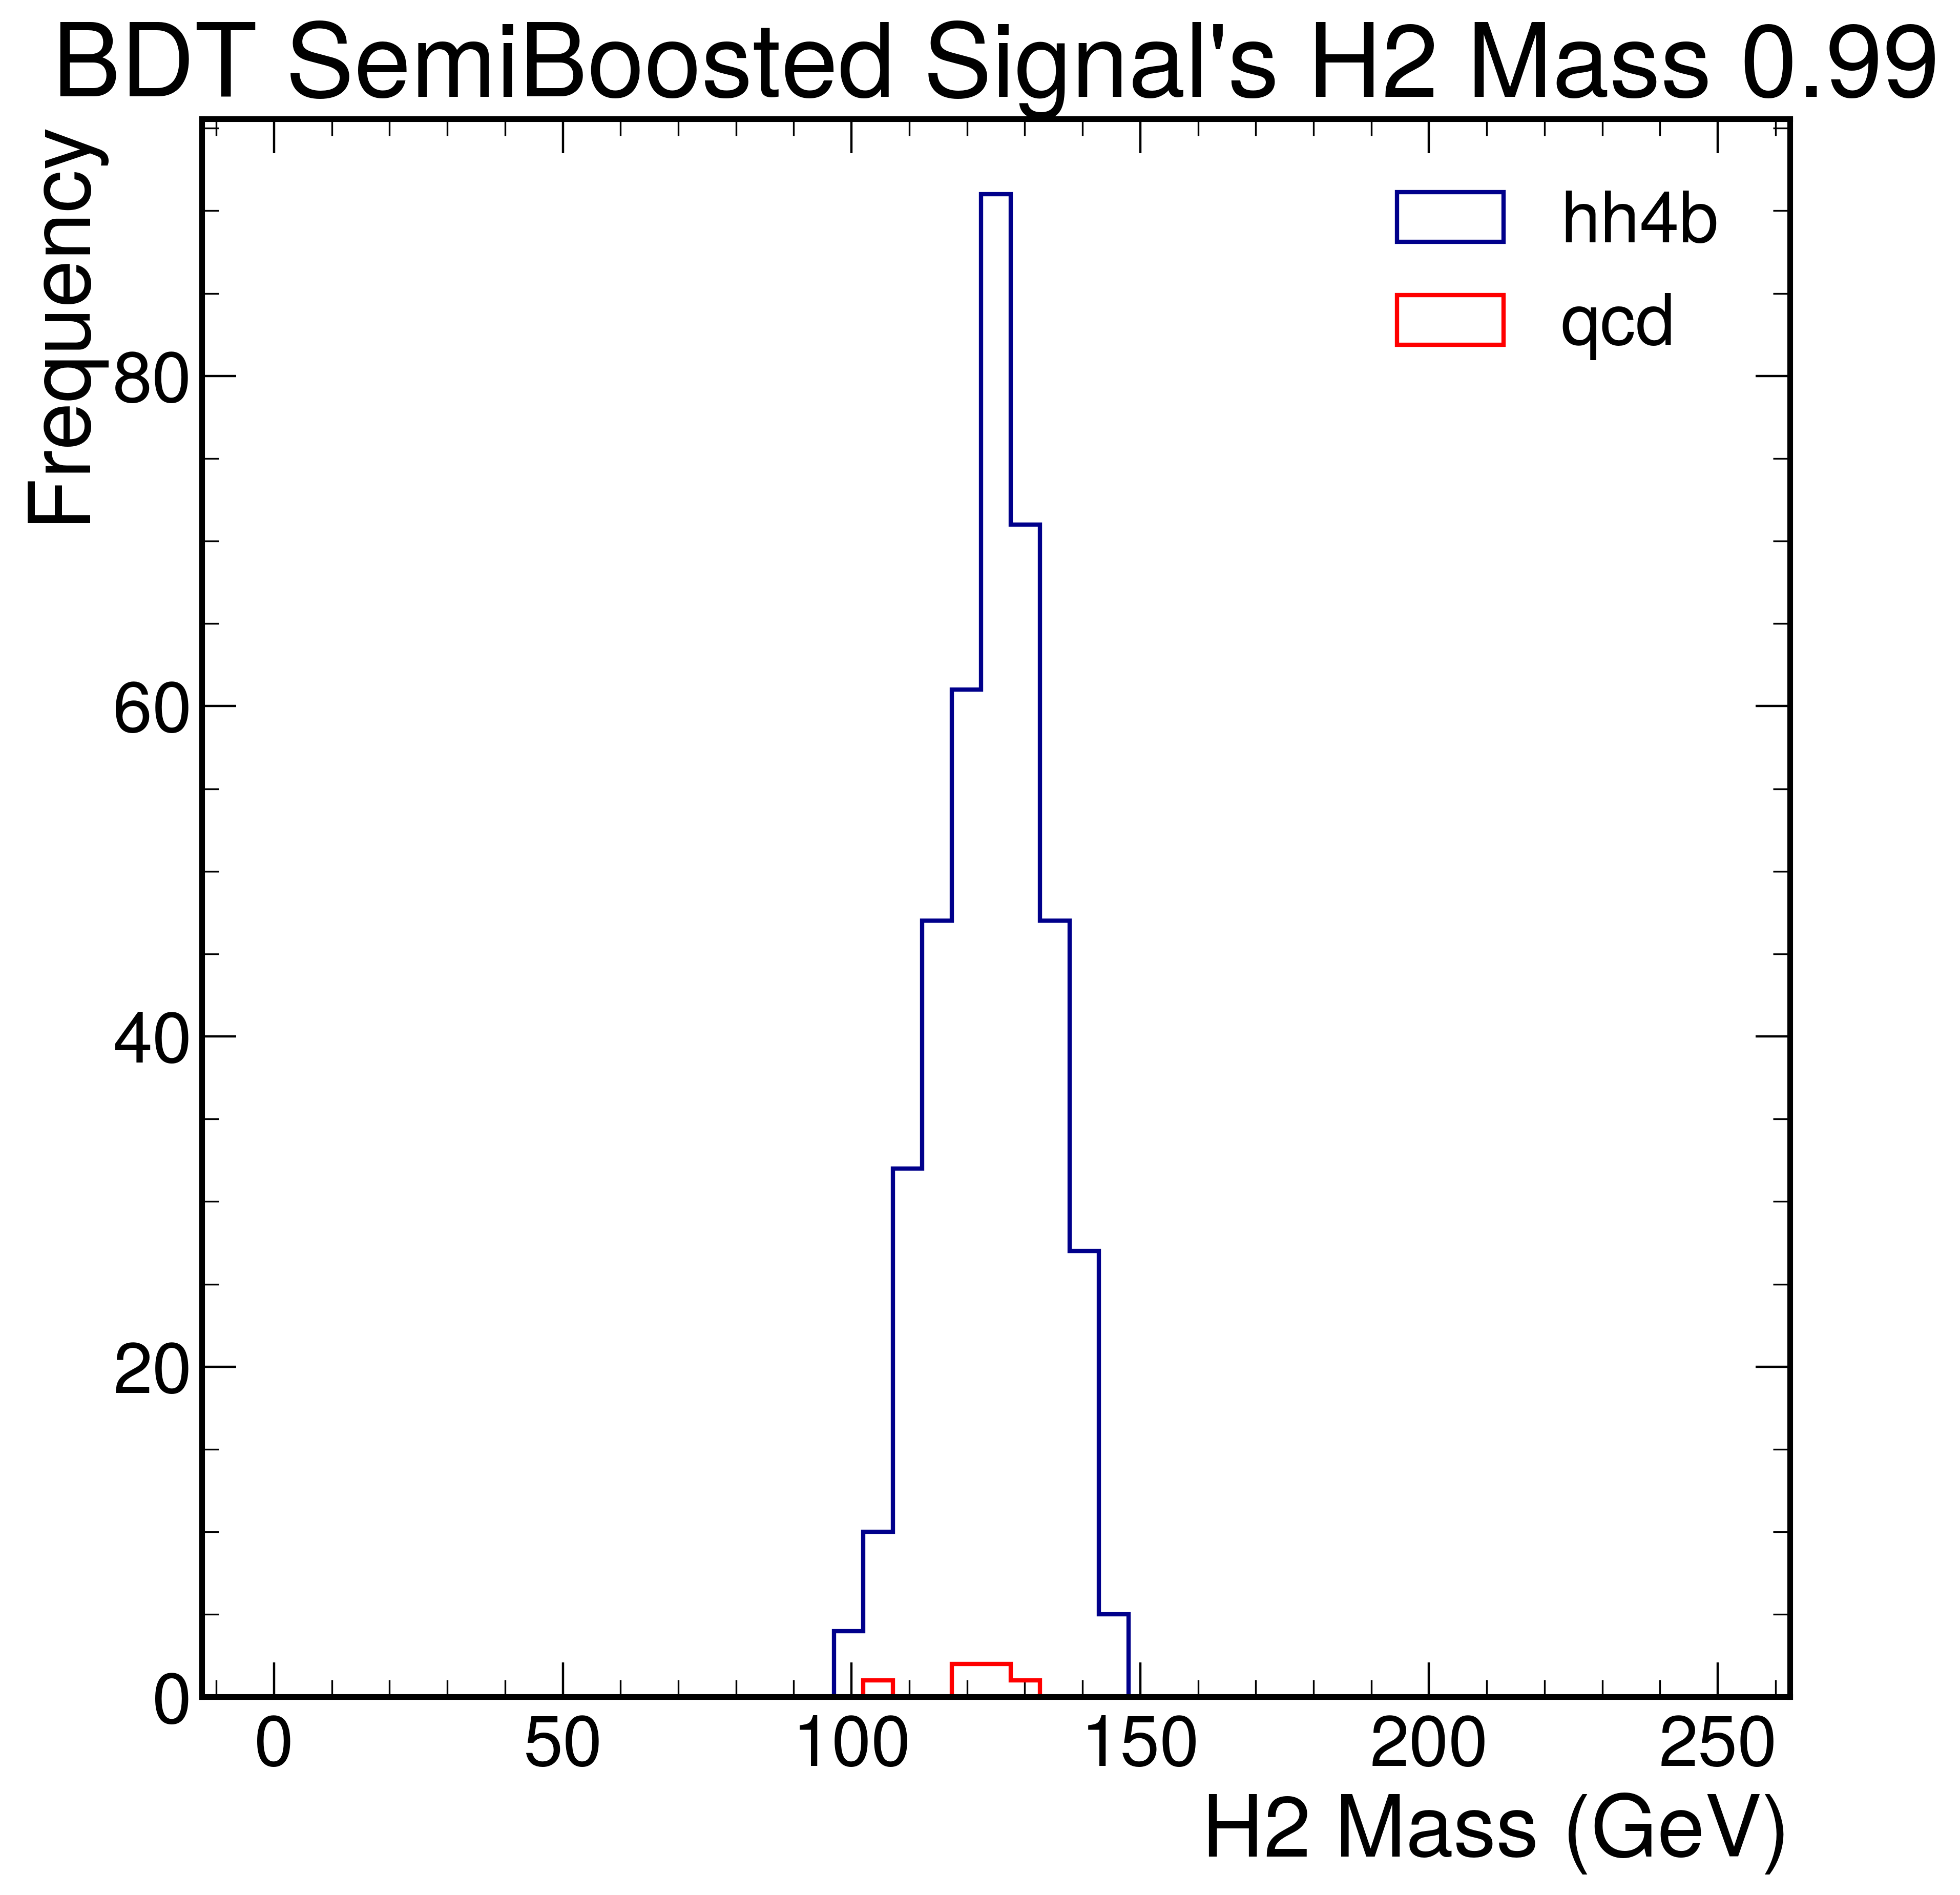

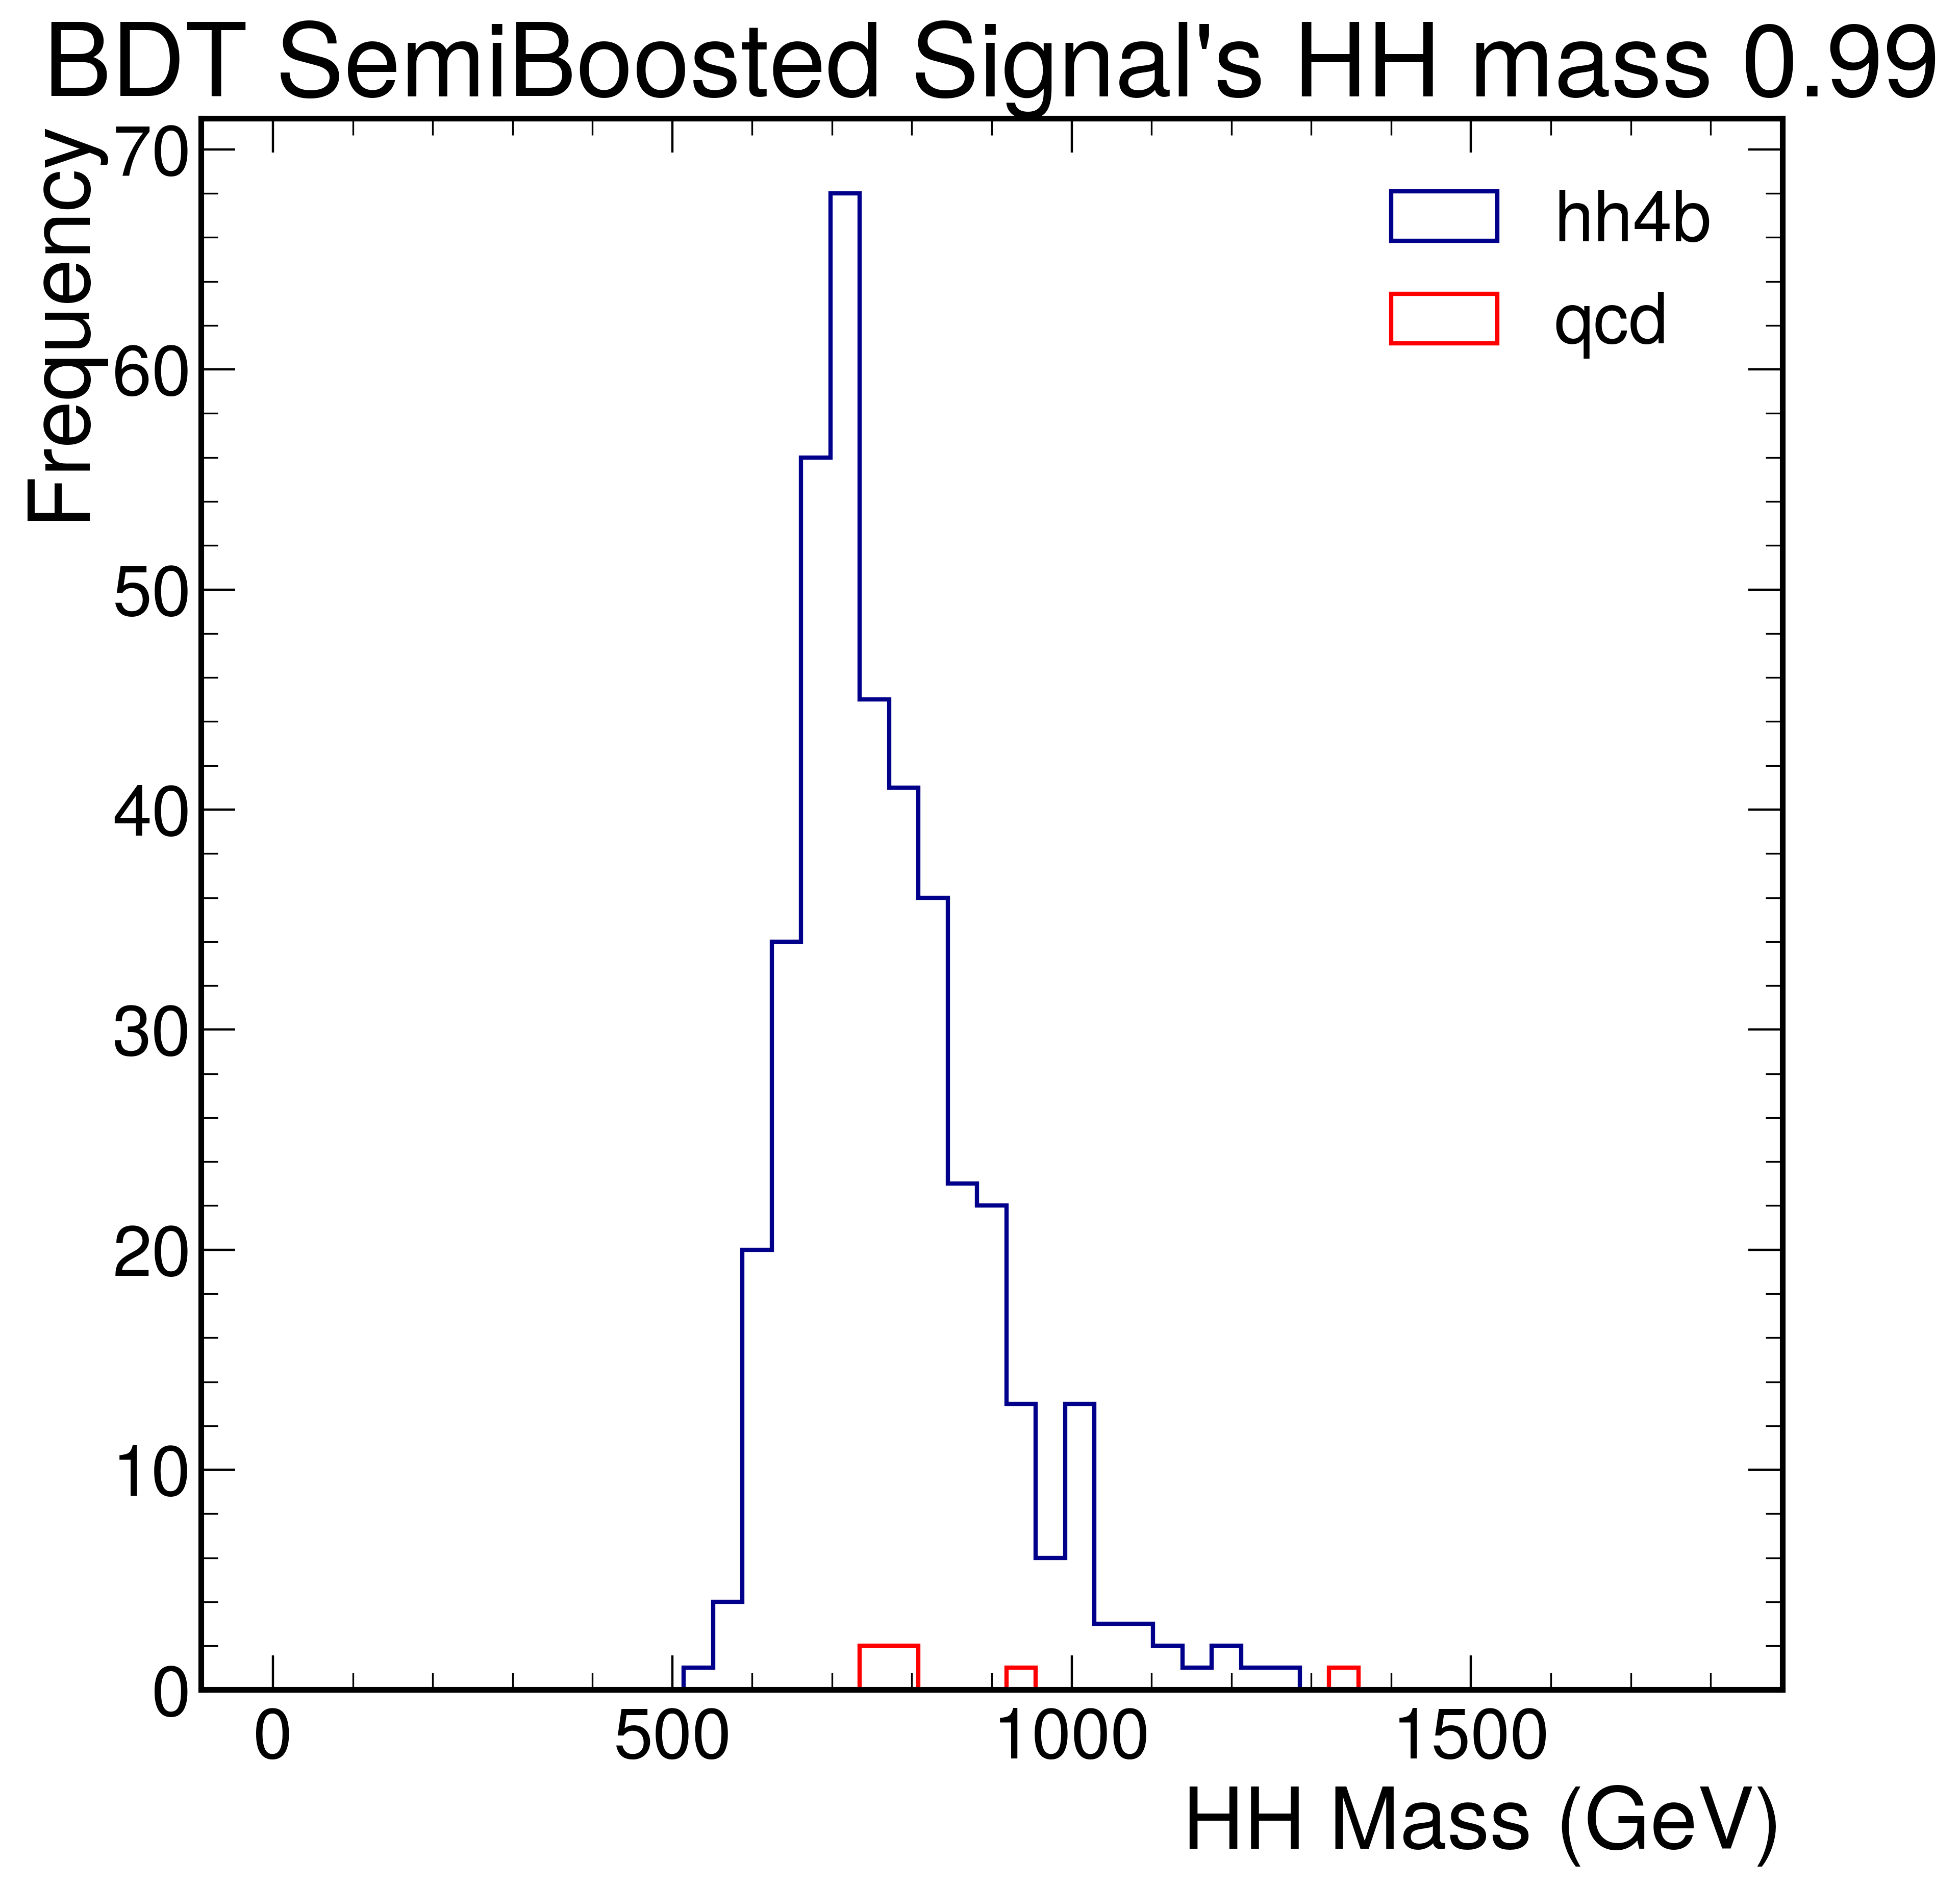

In [85]:
analyze_SemiBoosted_BDT_output(events_test, BDT_scores, 0.99, "0.99")